# Chemically-Informed Bayesian Optimization for Cu₃VS₄ Nanoparticle Synthesis

## A Surrogate Model Approach with Domain Knowledge Integration

---

### Overview

This notebook implements a **hierarchical Bayesian optimization framework** that combines:

1. **Raw synthesis parameters** (what you control in the lab)
2. **Chemically-derived features** (stoichiometric ratios, concentrations)
3. **Proper uncertainty quantification** (GP posteriors with calibration checks)
4. **Interpretability tools** (Partial Dependence Plots for mechanism insight)

### Problem Formulation

**Goal**: Given a target particle size, find synthesis conditions that:
- Hit the target size (within tolerance)
- Minimize GSD (toward 1.0 = monodisperse)
- Maximize Squareness (toward 1.0 = cubic)
- Ensure phase purity and cubic polymorph

### Hierarchical Structure

```
Level 1: Feasibility Classification
    ├── HasProduct (did reaction work?)
    ├── PhasePure (single phase Cu₃VS₄?)
    └── IsCubic (cubic polymorph?)

Level 2: Property Regression (conditional on feasibility)
    ├── Size (nm)
    ├── GSD (geometric standard deviation)
    └── Squareness (morphology metric)
```

### Chemical Features

| Feature | Formula | Chemical Meaning |
|---------|---------|------------------|
| Cu_V_ratio | CuI / VOacac | Stoichiometry (target = 3.0 for Cu₃VS₄) |
| S_Metal_ratio | DDT_mmol / (CuI + VOacac) | Sulfur excess driving nucleation |
| Ligand_Metal_ratio | OAm_mmol / (CuI + VOacac) | Surface capping density |
| Metal_Conc | (CuI + VOacac) / V_total | Total metal concentration (mM) |
| log_Time | log₁₀(Time) | Linearized reaction kinetics |

### References
- Jones et al. (1998) - Efficient Global Optimization
- Gelbart et al. (2014) - Bayesian Optimization with Unknown Constraints
- Raccuglia et al. (2016) Nature - ML-assisted materials discovery

---

In [120]:
# =============================================================================
# IMPORTS
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Any, Callable
import warnings
from copy import deepcopy

# ML imports
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Statistical imports
from scipy.stats import norm, spearmanr
from scipy.spatial.distance import cdist
from scipy.stats.qmc import LatinHypercube

from datetime import datetime

warnings.filterwarnings('ignore')
np.random.seed(42)

print("Imports successful!")

Imports successful!


In [121]:
# =============================================================================
# PUBLICATION STYLE
# =============================================================================
def set_publication_style():
    plt.rcParams.update({
        'figure.dpi': 150,
        'savefig.dpi': 300,
        'font.size': 10,
        'axes.titlesize': 11,
        'axes.labelsize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'figure.figsize': (6, 4),
        'axes.linewidth': 0.8,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'font.family': 'sans-serif',
    })

set_publication_style()

COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72', 
    'tertiary': '#F18F01',
    'success': '#2E8B57',
    'warning': '#E63946',
    'neutral': '#6C757D',
}

---
## 1. Configuration

Edit `DATA_PATH` and system constants for your setup.

In [122]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Data path - supports relative path or environment variable override
from pathlib import Path
import os

# Default: try relative path (go up one level from Notebooks/ to project root, then into Data/)
# This works if notebook is in Notebooks/ folder and data is in Data/ folder at project root
DEFAULT_RELATIVE = Path("..") / "Data" / "COMPLETE_CUVS_DATA_SIDE2.csv"

# Absolute path as fallback (your specific location)
ABSOLUTE_PATH = Path("/Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Data/COMPLETE_CUVS_DATA_SIDE2.csv")

# Allow override via environment variable
env_path = os.getenv("CUVS_DATA_PATH")
if env_path:
    DATA_PATH = Path(env_path).expanduser()
elif DEFAULT_RELATIVE.exists():
    DATA_PATH = DEFAULT_RELATIVE.resolve()
elif ABSOLUTE_PATH.exists():
    DATA_PATH = ABSOLUTE_PATH
else:
    # Try relative from current working directory (if running from project root)
    alt_relative = Path("Data") / "COMPLETE_CUVS_DATA_SIDE2.csv"
    if alt_relative.exists():
        DATA_PATH = alt_relative.resolve()
    else:
        raise FileNotFoundError(
            f"Data file not found. Tried:\n"
            f"  1. Relative (from Notebooks/): {DEFAULT_RELATIVE.resolve()}\n"
            f"  2. Absolute: {ABSOLUTE_PATH}\n"
            f"  3. Relative (from project root): {alt_relative.resolve()}\n"
            f"Set CUVS_DATA_PATH environment variable to specify custom path."
        )

print(f"Using data file: {DATA_PATH}")

# =============================================================================
# OUTPUT DIRECTORY CONFIGURATION
# =============================================================================
# All outputs (figures, CSVs) will be saved here
# Default: Outputs/ folder at project root (one level up from Notebooks/)
OUTPUT_DIR = Path("..") / "Outputs"
# Alternative: Use absolute path or create new folder
# OUTPUT_DIR = Path("/Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs")

# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR.resolve()}")

# =============================================================================
# SYSTEM CONSTANTS
# =============================================================================
CUI_MMOL = 0.25              # Fixed CuI amount (mmol)
TOTAL_VOLUME_ML = 12.0       # Fixed total volume (mL)
DDT_MMOL_PER_ML = 4.17       # DDT conversion (MW=202.4, ρ=0.845)
OAM_MMOL_PER_ML = 3.04       # OAm conversion (MW=267.5, ρ=0.813)

# =============================================================================
# FACTOR DEFINITIONS
# =============================================================================
RAW_FACTORS = ["Temp", "Time", "VOacac", "DDT", "OAm"]

# Chemical features derived from raw factors
CHEM_FEATURES = [
    "Cu_V_ratio",         # Stoichiometry
    "S_Metal_ratio",      # Sulfur excess
    "Ligand_Metal_ratio", # Capping density
    "Metal_Conc",         # Total metal concentration
    "log_Time",           # Linearized kinetics
]

# Hybrid feature set: raw factors + key chemical insights
HYBRID_FEATURES = RAW_FACTORS + ["Cu_V_ratio", "Metal_Conc"]

# =============================================================================
# BOUNDS
# =============================================================================
RAW_BOUNDS = {
    "Temp":   (260.0, 310.0),
    "Time":   (8.0, 90.0),
    "VOacac": (0.08, 0.66),
    "DDT":    (1.0, 5.0),
    "OAm":    (1.0, 7.0),
}

# =============================================================================
# OBJECTIVES & FEASIBILITY
# =============================================================================
OBJECTIVES = ["Size", "GSD", "Squareness"]
FEAS_COLS = ["HasProduct", "PhasePure"]
POLYMORPH_COL = "Polymorph"
CUBIC_LABEL = "cubic"

# Objective weights for multi-objective acquisition
# These will be calculated statistically after models are built
# Set to None to use automatic calculation, or provide manual weights
OBJECTIVE_WEIGHTS = None  # Will be calculated based on data and model performance

Using data file: /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Data/COMPLETE_CUVS_DATA_SIDE2.csv
Output directory: /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Outputs


---
## 2. Feature Engineering

Transform raw synthesis parameters into chemically meaningful descriptors.

In [123]:
# =============================================================================
# FEATURE TRANSFORMATION
# =============================================================================

def raw_to_chemical_features(
    Temp: np.ndarray,
    Time: np.ndarray,
    VOacac: np.ndarray,
    DDT: np.ndarray,
    OAm: np.ndarray,
    CuI: float = CUI_MMOL,
    total_vol: float = TOTAL_VOLUME_ML,
    ddt_conv: float = DDT_MMOL_PER_ML,
    oam_conv: float = OAM_MMOL_PER_ML,
) -> Dict[str, np.ndarray]:
    """
    Transform raw synthesis parameters into chemically meaningful features.
    
    Returns
    -------
    dict with:
        - Cu_V_ratio: Stoichiometry (target = 3.0 for Cu₃VS₄)
        - S_Metal_ratio: Sulfur excess
        - Ligand_Metal_ratio: Surface capping
        - Metal_Conc: Total metal concentration (mM)
        - log_Time: log₁₀(Time)
    """
    Temp = np.atleast_1d(Temp).astype(float)
    Time = np.atleast_1d(Time).astype(float)
    VOacac = np.atleast_1d(VOacac).astype(float)
    DDT = np.atleast_1d(DDT).astype(float)
    OAm = np.atleast_1d(OAm).astype(float)
    
    total_metal = CuI + VOacac
    DDT_mmol = DDT * ddt_conv
    OAm_mmol = OAm * oam_conv
    
    return {
        'Temp': Temp,
        'Cu_V_ratio': CuI / VOacac,
        'S_Metal_ratio': DDT_mmol / total_metal,
        'Ligand_Metal_ratio': OAm_mmol / total_metal,
        'Metal_Conc': (total_metal / total_vol) * 1000,  # Convert to mM
        'log_Time': np.log10(np.maximum(Time, 1.0)),
    }


def chemical_to_raw_features(
    Temp: np.ndarray,
    Cu_V_ratio: np.ndarray,
    S_Metal_ratio: np.ndarray,
    Ligand_Metal_ratio: np.ndarray,
    Metal_Conc: np.ndarray,
    log_Time: np.ndarray,
    CuI: float = CUI_MMOL,
    total_vol: float = TOTAL_VOLUME_ML,
    ddt_conv: float = DDT_MMOL_PER_ML,
    oam_conv: float = OAM_MMOL_PER_ML,
) -> Dict[str, np.ndarray]:
    """
    Convert chemical features back to raw lab parameters.
    """
    Temp = np.atleast_1d(Temp)
    Cu_V_ratio = np.atleast_1d(Cu_V_ratio)
    S_Metal_ratio = np.atleast_1d(S_Metal_ratio)
    Ligand_Metal_ratio = np.atleast_1d(Ligand_Metal_ratio)
    Metal_Conc = np.atleast_1d(Metal_Conc)
    log_Time = np.atleast_1d(log_Time)
    
    Time = 10 ** log_Time
    VOacac = CuI / Cu_V_ratio
    total_metal = CuI + VOacac
    DDT_mmol = S_Metal_ratio * total_metal
    OAm_mmol = Ligand_Metal_ratio * total_metal
    DDT = DDT_mmol / ddt_conv
    OAm = OAm_mmol / oam_conv
    
    return {
        'Temp': Temp,
        'Time': Time,
        'VOacac': VOacac,
        'DDT': DDT,
        'OAm': OAm,
    }


def add_chemical_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add all chemical features to a dataframe.
    """
    df = df.copy()
    
    chem = raw_to_chemical_features(
        Temp=df['Temp'].values,
        Time=df['Time'].values,
        VOacac=df['VOacac'].values,
        DDT=df['DDT'].values,
        OAm=df['OAm'].values,
    )
    
    for name, values in chem.items():
        if name != 'Temp':  # Don't duplicate Temp
            df[name] = values
    
    return df


def compute_feature_bounds(feature_list: List[str], df: pd.DataFrame) -> Dict[str, Tuple[float, float]]:
    """
    Compute bounds for any feature list from observed data.
    
    Handles edge cases:
    - Uses RAW_BOUNDS if available (for raw factors)
    - Computes from data with proper margin
    - Handles single value or empty cases
    """
    bounds = {}
    for feat in feature_list:
        if feat in RAW_BOUNDS:
            bounds[feat] = RAW_BOUNDS[feat]
        elif feat in df.columns:
            vals = df[feat].dropna()
            if len(vals) == 0:
                raise ValueError(f"No valid values found for feature '{feat}'")
            elif len(vals) == 1:
                # Single value: use wider margin
                val = vals.iloc[0]
                margin = abs(val) * 0.1 if abs(val) > 1e-6 else 0.1
                bounds[feat] = (val - margin, val + margin)
            else:
                # Multiple values: use 5% margin
                margin = 0.05 * (vals.max() - vals.min())
                bounds[feat] = (vals.min() - margin, vals.max() + margin)
        else:
            raise ValueError(f"Feature '{feat}' not found in dataframe and not in RAW_BOUNDS")
    return bounds

---
## 3. Data Loading

In [124]:
# =============================================================================
# DATA LOADING
# =============================================================================

def load_data(path) -> pd.DataFrame:
    """
    Load and prepare the dataset.
    
    Parameters
    ----------
    path : str or Path
        Path to data file
    """
    from pathlib import Path
    path_obj = Path(path)
    if not path_obj.exists():
        raise FileNotFoundError(
            f"Data file not found: {path}\n"
            f"Please check the path and ensure the file exists."
        )
    
    if path_obj.suffix == '.csv':
        df = pd.read_csv(path_obj)
    elif path_obj.suffix in ('.xlsx', '.xls'):
        df = pd.read_excel(path_obj)
    else:
        raise ValueError(f"Unsupported format: {path_obj.suffix}")
    
    df.columns = [c.strip() for c in df.columns]
    
    # Validate
    required = RAW_FACTORS + OBJECTIVES + FEAS_COLS
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    
    # Coerce types
    for col in RAW_FACTORS + OBJECTIVES:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    for col in FEAS_COLS:
        df[col] = df[col].fillna(0).astype(bool).astype(int)
    
    # IsCubic
    if POLYMORPH_COL in df.columns:
        df["IsCubic"] = (
            df[POLYMORPH_COL].fillna("").astype(str).str.lower().str.strip() 
            == CUBIC_LABEL.lower()
        ).astype(int)
    else:
        df["IsCubic"] = df["HasProduct"].values
    
    # Drop rows missing factors
    df = df.dropna(subset=RAW_FACTORS).reset_index(drop=True)
    
    # Add chemical features
    df = add_chemical_features(df)
    
    return df


# Load data (DATA_PATH is already a Path object with existence check)
df = load_data(str(DATA_PATH))  # Convert to string for compatibility
df_success = df[df["HasProduct"] == 1].copy()

print("=" * 60)
print("DATASET LOADED")
print("=" * 60)
print(f"Data file:             {DATA_PATH}")
print(f"Total experiments:     {len(df)}")
print(f"Successful (product):  {len(df_success)}")
print(f"Phase pure:            {df['PhasePure'].sum()}")
print(f"Cubic:                 {df['IsCubic'].sum()}")

DATASET LOADED
Data file:             /Users/ariananygren/Desktop/phd files/Projects/Cu3VS4/CuVS_BO_Code/Data/COMPLETE_CUVS_DATA_SIDE2.csv
Total experiments:     41
Successful (product):  31
Phase pure:            17
Cubic:                 27


In [125]:
# =============================================================================
# DATA SUMMARY
# =============================================================================

print("\n" + "=" * 60)
print("CHEMICAL FEATURE SUMMARY")
print("=" * 60)

print("\nAll Experiments:")
display(df[CHEM_FEATURES].describe().round(3))

print("\nSuccessful Experiments - Objectives:")
display(df_success[OBJECTIVES].describe().round(3))

# Key insight: Cu_V_ratio distribution
print("\n" + "-" * 60)
print("Cu:V RATIO DISTRIBUTION (target = 3.0 for Cu₃VS₄)")
print("-" * 60)
cuv = df['Cu_V_ratio']
print(f"  Min:    {cuv.min():.2f}")
print(f"  Max:    {cuv.max():.2f}")
print(f"  Mean:   {cuv.mean():.2f}")
print(f"  Median: {cuv.median():.2f}")
print(f"\n  Points with Cu:V > 2.0: {(cuv > 2.0).sum()}")
print(f"  Points with Cu:V > 2.5: {(cuv > 2.5).sum()}")
print(f"  Points with Cu:V ≈ 3.0 (±0.5): {((cuv > 2.5) & (cuv < 3.5)).sum()}")


CHEMICAL FEATURE SUMMARY

All Experiments:


,Cu_V_ratio,S_Metal_ratio,Ligand_Metal_ratio,Metal_Conc,log_Time
count,41.000,41.000,41.000,41.000,41.000
mean,1.426,23.238,22.918,51.028,1.520
std,1.220,18.804,19.505,20.475,0.454
min,0.379,4.582,3.341,27.500,0.903
25%,0.379,12.636,9.212,27.500,0.903
50%,0.676,20.142,19.613,51.667,1.690
75%,3.125,22.912,23.385,75.833,1.954
max,3.125,63.182,64.485,75.833,1.954



Successful Experiments - Objectives:


,Size,GSD,Squareness
count,31.000,31.000,31.000
mean,20.155,1.368,0.511
std,8.159,0.199,0.060
min,10.188,1.132,0.368
25%,13.846,1.229,0.487
50%,19.535,1.296,0.525
75%,22.152,1.505,0.548
max,44.961,1.918,0.605



------------------------------------------------------------
Cu:V RATIO DISTRIBUTION (target = 3.0 for Cu₃VS₄)
------------------------------------------------------------
  Min:    0.38
  Max:    3.12
  Mean:   1.43
  Median: 0.68

  Points with Cu:V > 2.0: 13
  Points with Cu:V > 2.5: 13
  Points with Cu:V ≈ 3.0 (±0.5): 13


---
## 4. GP Model Components

In [126]:
# =============================================================================
# GP BUILDERS
# =============================================================================

def make_gp_regressor(n_features: int) -> GaussianProcessRegressor:
    """Create GP regressor with Matérn 5/2 ARD kernel."""
    kernel = (
        C(1.0, (0.001, 1000.0)) * 
        Matern(
            length_scale=[1.0] * n_features,
            length_scale_bounds=(0.01, 100.0),
            nu=2.5
        ) +
        WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-8, 1.0))
    )
    
    return GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=True,
        n_restarts_optimizer=15,
        random_state=42,
        alpha=1e-10
    )


def make_gp_classifier(n_features: int) -> GaussianProcessClassifier:
    """Create GP classifier for feasibility."""
    kernel = C(1.0, (0.01, 100.0)) * Matern(
        length_scale=[1.0] * n_features,
        length_scale_bounds=(0.1, 10.0),
        nu=2.5
    )
    
    return GaussianProcessClassifier(
        kernel=kernel,
        n_restarts_optimizer=5,
        random_state=42,
        max_iter_predict=200
    )

In [127]:
# =============================================================================
# ACQUISITION FUNCTIONS
# =============================================================================

def expected_improvement(
    mu: np.ndarray,
    sigma: np.ndarray,
    y_best: float,
    xi: float = 0.01,
    minimize: bool = True
) -> np.ndarray:
    """Expected Improvement acquisition function."""
    sigma = np.maximum(sigma, 1e-9)
    
    if minimize:
        improvement = y_best - mu - xi
    else:
        improvement = mu - y_best - xi
    
    z = improvement / sigma
    ei = improvement * norm.cdf(z) + sigma * norm.pdf(z)
    
    return np.maximum(ei, 0.0)


def prob_in_interval(
    mu: np.ndarray,
    sigma: np.ndarray,
    target: float,
    tolerance: float
) -> np.ndarray:
    """P(target - tol ≤ Y ≤ target + tol)."""
    sigma = np.maximum(sigma, 1e-9)
    z_hi = (target + tolerance - mu) / sigma
    z_lo = (target - tolerance - mu) / sigma
    return norm.cdf(z_hi) - norm.cdf(z_lo)

In [128]:
# =============================================================================
# SAMPLING
# =============================================================================

def latin_hypercube_sample(
    n_samples: int,
    bounds: Dict[str, Tuple[float, float]],
    feature_order: List[str],
    seed: Optional[int] = None
) -> np.ndarray:
    """Generate LHS samples."""
    n_dims = len(feature_order)
    sampler = LatinHypercube(d=n_dims, seed=seed)
    samples = sampler.random(n=n_samples)
    
    lows = np.array([bounds[k][0] for k in feature_order])
    highs = np.array([bounds[k][1] for k in feature_order])
    
    return samples * (highs - lows) + lows

In [129]:
# =============================================================================
# STATISTICAL WEIGHT CALCULATION
# =============================================================================

def calculate_objective_weights(
    df_success: pd.DataFrame,
    model_metrics: Optional[Dict[str, Dict[str, float]]] = None,
    method: str = 'comprehensive'
) -> Dict[str, float]:
    """
    Calculate statistically sound objective weights based on data and model performance.
    
    Parameters
    ----------
    df_success : DataFrame
        Successful experiments with objective values
    model_metrics : dict, optional
        Model performance metrics (from LOO-CV) with keys like:
        {'GSD': {'r2': 0.5, 'rmse': 0.2}, 'Squareness': {...}}
    method : str
        'comprehensive' (default): Uses multiple factors
        'variability': Based on coefficient of variation
        'uncertainty': Based on model uncertainty (RMSE)
        'improvement': Based on improvement potential
    
    Returns
    -------
    dict : Objective weights for GSD and Squareness
    """
    weights = {}
    
    # Extract data statistics
    gsd_data = df_success['GSD'].values
    sq_data = df_success['Squareness'].values
    
    # Calculate coefficient of variation (CV)
    cv_gsd = np.std(gsd_data) / (np.mean(gsd_data) + 1e-10)
    cv_sq = np.std(sq_data) / (np.mean(sq_data) + 1e-10)
    
    # Calculate improvement potential (normalized range)
    # For GSD: lower is better, so improvement = (max - min) / mean
    # For Squareness: higher is better, so improvement = (max - min) / mean
    gsd_range = (gsd_data.max() - gsd_data.min()) / (np.mean(gsd_data) + 1e-10)
    sq_range = (sq_data.max() - sq_data.min()) / (np.mean(sq_data) + 1e-10)
    
    # Calculate distance from ideal
    # GSD ideal = 1.0 (monodisperse), Squareness ideal = 1.0 (perfect cube)
    gsd_ideal = 1.0
    sq_ideal = 1.0
    gsd_distance = np.abs(np.mean(gsd_data) - gsd_ideal) / (np.std(gsd_data) + 1e-10)
    sq_distance = np.abs(np.mean(sq_data) - sq_ideal) / (np.std(sq_data) + 1e-10)
    
    if method == 'variability':
        # Weight by coefficient of variation (more variable = more important to optimize)
        w_gsd = cv_gsd
        w_sq = cv_sq
        
    elif method == 'uncertainty':
        # Weight by model uncertainty (if metrics provided)
        if model_metrics is None:
            raise ValueError("model_metrics required for 'uncertainty' method")
        
        # Use RMSE as proxy for uncertainty
        # Higher RMSE = more uncertain = more room for improvement
        rmse_gsd = model_metrics.get('GSD', {}).get('rmse', 0.1)
        rmse_sq = model_metrics.get('Squareness', {}).get('rmse', 0.1)
        
        # Normalize by data scale
        w_gsd = rmse_gsd / (np.mean(gsd_data) + 1e-10)
        w_sq = rmse_sq / (np.mean(sq_data) + 1e-10)
        
    elif method == 'improvement':
        # Weight by improvement potential
        w_gsd = gsd_range
        w_sq = sq_range
        
    elif method == 'comprehensive':
        # Combine multiple factors
        factors_gsd = []
        factors_sq = []
        
        # Factor 1: Coefficient of variation (variability)
        factors_gsd.append(cv_gsd)
        factors_sq.append(cv_sq)
        
        # Factor 2: Improvement potential (normalized range)
        factors_gsd.append(gsd_range)
        factors_sq.append(sq_range)
        
        # Factor 3: Distance from ideal (normalized)
        factors_gsd.append(gsd_distance)
        factors_sq.append(sq_distance)
        
        # Factor 4: Model uncertainty (if available)
        if model_metrics is not None:
            rmse_gsd = model_metrics.get('GSD', {}).get('rmse', 0.1)
            rmse_sq = model_metrics.get('Squareness', {}).get('rmse', 0.1)
            
            # Normalize RMSE by data scale
            rmse_gsd_norm = rmse_gsd / (np.mean(gsd_data) + 1e-10)
            rmse_sq_norm = rmse_sq / (np.mean(sq_data) + 1e-10)
            
            factors_gsd.append(rmse_gsd_norm)
            factors_sq.append(rmse_sq_norm)
            
            # Factor 5: Model reliability (inverse of R², but handle negative R²)
            r2_gsd = model_metrics.get('GSD', {}).get('r2', 0.0)
            r2_sq = model_metrics.get('Squareness', {}).get('r2', 0.0)
            
            # Convert R² to uncertainty: (1 - R²) for positive R², (1 + |R²|) for negative
            if r2_gsd >= 0:
                reliability_gsd = 1.0 - r2_gsd
            else:
                reliability_gsd = 1.0 + abs(r2_gsd)
                
            if r2_sq >= 0:
                reliability_sq = 1.0 - r2_sq
            else:
                reliability_sq = 1.0 + abs(r2_sq)
            
            factors_gsd.append(reliability_gsd)
            factors_sq.append(reliability_sq)
        
        # Geometric mean of factors (more robust than arithmetic mean)
        w_gsd = np.prod([f for f in factors_gsd if f > 0]) ** (1.0 / len(factors_gsd))
        w_sq = np.prod([f for f in factors_sq if f > 0]) ** (1.0 / len(factors_sq))
        
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Normalize weights (so they sum to a reasonable total, but preserve ratio)
    # Use softmax-like normalization to prevent extreme values
    total = w_gsd + w_sq
    if total > 0:
        # Scale to have a reasonable magnitude (e.g., sum to 2.0)
        scale = 2.0 / total
        w_gsd *= scale
        w_sq *= scale
    else:
        # Fallback to equal weights
        w_gsd = 1.0
        w_sq = 1.0
    
    return {
        'GSD': float(w_gsd),
        'Squareness': float(w_sq)
    }


def print_weight_calculation_report(
    df_success: pd.DataFrame,
    weights: Dict[str, float],
    model_metrics: Optional[Dict[str, Dict[str, float]]] = None
):
    """Print a detailed report on weight calculation."""
    print("\n" + "=" * 70)
    print("OBJECTIVE WEIGHT CALCULATION REPORT")
    print("=" * 70)
    
    gsd_data = df_success['GSD'].values
    sq_data = df_success['Squareness'].values
    
    print("\nData Statistics:")
    print(f"  GSD:      mean={np.mean(gsd_data):.3f}, std={np.std(gsd_data):.3f}, "
          f"CV={np.std(gsd_data)/np.mean(gsd_data):.3f}, range=[{gsd_data.min():.3f}, {gsd_data.max():.3f}]")
    print(f"  Squareness: mean={np.mean(sq_data):.3f}, std={np.std(sq_data):.3f}, "
          f"CV={np.std(sq_data)/np.mean(sq_data):.3f}, range=[{sq_data.min():.3f}, {sq_data.max():.3f}]")
    
    if model_metrics:
        print("\nModel Performance:")
        for obj in ['GSD', 'Squareness']:
            m = model_metrics.get(obj, {})
            print(f"  {obj}: R²={m.get('r2', np.nan):.3f}, RMSE={m.get('rmse', np.nan):.3f}")
    
    print("\nCalculated Weights:")
    print(f"  GSD:      {weights['GSD']:.3f}")
    print(f"  Squareness: {weights['Squareness']:.3f}")
    print(f"  Ratio (GSD/Squareness): {weights['GSD']/weights['Squareness']:.3f}")
    print("\nInterpretation:")
    print("  - Higher weight = more emphasis on optimizing this objective")
    print("  - Weights are normalized to preserve relative importance")
    print("=" * 70)

In [130]:
# =============================================================================
# CROSS-VALIDATION
# =============================================================================

def loo_cv(
    X: np.ndarray,
    y: np.ndarray,
    gp_factory: Callable,
    return_predictions: bool = False
) -> Dict[str, Any]:
    """Leave-One-Out CV with proper re-fitting."""
    n = len(y)
    y_pred = np.zeros(n)
    y_std = np.zeros(n)
    
    for train_idx, test_idx in LeaveOneOut().split(X):
        gp = gp_factory()
        gp.fit(X[train_idx], y[train_idx])
        mu, std = gp.predict(X[test_idx], return_std=True)
        y_pred[test_idx] = mu
        y_std[test_idx] = std
    
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    
    z = np.abs(y - y_pred) / np.maximum(y_std, 1e-9)
    cal_95 = np.mean(z < 1.96)
    cal_68 = np.mean(z < 1.0)
    
    result = {'r2': r2, 'rmse': rmse, 'mae': mae, 'cal_95': cal_95, 'cal_68': cal_68}
    
    if return_predictions:
        result['y_pred'] = y_pred
        result['y_std'] = y_std
    
    return result

---
## 5. Main Optimizer Class

In [131]:
# =============================================================================
# Cu₃VS₄ BAYESIAN OPTIMIZER
# =============================================================================

class Cu3VS4Optimizer:
    """
    Chemically-informed Bayesian Optimization for Cu₃VS₄ synthesis.
    
    Supports multiple feature representations:
    - 'raw': Original synthesis parameters
    - 'chemical': Fully transformed chemical features
    - 'hybrid': Raw parameters + key chemical insights
    
    Attributes
    ----------
    feature_mode : str
        'raw', 'chemical', or 'hybrid'
    features : list
        Feature names used for modeling
    gp_size, gp_gsd, gp_sq : GaussianProcessRegressor
        Property models
    clf_product, clf_pure, clf_cubic : GaussianProcessClassifier
        Feasibility classifiers
    metrics : dict
        Cross-validation metrics
    """
    
    def __init__(
        self,
        df: pd.DataFrame,
        feature_mode: str = 'hybrid',
        validate: bool = True
    ):
        """
        Initialize optimizer.
        
        Parameters
        ----------
        df : DataFrame
            Full dataset with raw factors and chemical features
        feature_mode : str
            'raw', 'chemical', or 'hybrid'
        validate : bool
            Run LOO-CV during initialization
        """
        self.feature_mode = feature_mode
        
        # Select features based on mode
        if feature_mode == 'raw':
            self.features = RAW_FACTORS
        elif feature_mode == 'chemical':
            self.features = CHEM_FEATURES
        elif feature_mode == 'hybrid':
            self.features = HYBRID_FEATURES
        else:
            raise ValueError(f"Unknown feature_mode: {feature_mode}")
        
        # Store data
        self.df_all = df.copy()
        self.df_success = df[df["HasProduct"] == 1].copy()
        
        if len(self.df_success) < 5:
            raise ValueError(f"Need ≥5 successful experiments")
        
        # Extract features
        self.X_all = self.df_all[self.features].values.astype(float)
        self.X_success = self.df_success[self.features].values.astype(float)
        
        # Fit scaler
        self.scaler = StandardScaler()
        self.scaler.fit(self.X_all)
        self.X_all_scaled = self.scaler.transform(self.X_all)
        self.X_success_scaled = self.scaler.transform(self.X_success)
        
        # Compute bounds
        self.bounds = compute_feature_bounds(self.features, self.df_all)
        
        # Build models
        self._build_models()
        
        # Validate
        self.metrics = {}
        if validate:
            self._validate()
    
    def _gp_factory(self):
        return make_gp_regressor(len(self.features))
    
    def _build_models(self):
        """Build and fit all models."""
        n = len(self.features)
        print(f"Building models with {n} features ({self.feature_mode} mode)...")
        
        # Regression
        self.gp_size = make_gp_regressor(n)
        self.gp_gsd = make_gp_regressor(n)
        self.gp_sq = make_gp_regressor(n)
        
        self.gp_size.fit(self.X_success_scaled, self.df_success["Size"].values)
        self.gp_gsd.fit(self.X_success_scaled, self.df_success["GSD"].values)
        self.gp_sq.fit(self.X_success_scaled, self.df_success["Squareness"].values)
        print(f"  Regression models fitted (n={len(self.df_success)})")
        
        # Classification
        self.clf_product = self._fit_clf("HasProduct")
        self.clf_pure = self._fit_clf("PhasePure")
        self.clf_cubic = self._fit_clf("IsCubic")
    
    def _fit_clf(self, col: str):
        y = self.df_all[col].values
        if len(np.unique(y)) < 2:
            print(f"  {col}: Single class, skipping")
            return None
        clf = make_gp_classifier(len(self.features))
        clf.fit(self.X_all_scaled, y.astype(int))
        print(f"  {col} classifier fitted")
        return clf
    
    def _validate(self):
        """Run LOO-CV."""
        print("\nRunning LOO cross-validation...")
        
        for name in ["Size", "GSD", "Squareness"]:
            y = self.df_success[name].values
            cv = loo_cv(self.X_success_scaled, y, self._gp_factory, return_predictions=True)
            self.metrics[name] = cv
            print(f"  {name}: R²={cv['r2']:.3f}, RMSE={cv['rmse']:.3f}")
    
    def predict(self, X: np.ndarray) -> Dict[str, np.ndarray]:
        """
        Predict all properties and feasibility.
        
        Parameters
        ----------
        X : array (n_samples, n_features)
            Feature values (in original scale)
        """
        X_scaled = self.scaler.transform(X)
        
        size_mu, size_std = self.gp_size.predict(X_scaled, return_std=True)
        gsd_mu, gsd_std = self.gp_gsd.predict(X_scaled, return_std=True)
        sq_mu, sq_std = self.gp_sq.predict(X_scaled, return_std=True)
        
        n = len(X)
        p_product = np.ones(n) if self.clf_product is None else self.clf_product.predict_proba(X_scaled)[:, 1]
        p_pure = np.ones(n) if self.clf_pure is None else self.clf_pure.predict_proba(X_scaled)[:, 1]
        p_cubic = np.ones(n) if self.clf_cubic is None else self.clf_cubic.predict_proba(X_scaled)[:, 1]
        
        return {
            'size_mu': size_mu, 'size_std': size_std,
            'gsd_mu': gsd_mu, 'gsd_std': gsd_std,
            'sq_mu': sq_mu, 'sq_std': sq_std,
            'p_product': p_product, 'p_pure': p_pure, 'p_cubic': p_cubic,
            'p_feasible': p_product * p_pure * p_cubic
        }
    
    def acquisition(
        self,
        X: np.ndarray,
        target_size: float,
        size_tol: float
    ) -> Dict[str, np.ndarray]:
        """Compute acquisition function."""
        preds = self.predict(X)
        
        gsd_best = self.df_success["GSD"].min()
        sq_best = self.df_success["Squareness"].max()
        
        ei_gsd = expected_improvement(preds['gsd_mu'], preds['gsd_std'], gsd_best, minimize=True)
        ei_sq = expected_improvement(preds['sq_mu'], preds['sq_std'], sq_best, minimize=False)
        
        # Normalize
        ei_gsd_n = (ei_gsd - ei_gsd.min()) / (np.ptp(ei_gsd) + 1e-10)
        ei_sq_n = (ei_sq - ei_sq.min()) / (np.ptp(ei_sq) + 1e-10)
        
        w_gsd = OBJECTIVE_WEIGHTS.get("GSD", 1.0)
        w_sq = OBJECTIVE_WEIGHTS.get("Squareness", 1.0)
        acq_obj = (w_gsd * ei_gsd_n + w_sq * ei_sq_n) / (w_gsd + w_sq)
        
        p_size = prob_in_interval(preds['size_mu'], preds['size_std'], target_size, size_tol)
        
        total = acq_obj * p_size * preds['p_feasible']
        
        return {'total': total, 'acq_obj': acq_obj, 'p_size': p_size, **preds}
    
    def recommend(
        self,
        target_size: float,
        size_tol: float = 2.5,
        p_size_min: float = 0.2,
        p_feas_min: float = 0.3,
        n_candidates: int = 20000,
        n_return: int = 5,
        min_distance: float = 0.3,
        seed: Optional[int] = None
    ) -> pd.DataFrame:
        """
        Recommend synthesis conditions for target size.
        
        Returns DataFrame with raw parameters (for lab) and predictions.
        """
        # Sample
        X = latin_hypercube_sample(n_candidates, self.bounds, self.features, seed)
        
        # Acquisition
        acq = self.acquisition(X, target_size, size_tol)
        
        # Filter
        mask = (acq['p_size'] >= p_size_min) & (acq['p_feasible'] >= p_feas_min)
        
        if mask.sum() == 0:
            print(f"[WARNING] No candidates meet constraints. Relaxing...")
            mask = np.ones(len(X), dtype=bool)
        
        X_feas = X[mask]
        acq_feas = acq['total'][mask]
        
        # Sort and select diverse
        order = np.argsort(acq_feas)[::-1]
        X_scaled = self.scaler.transform(X_feas)
        
        selected = []
        selected_scaled = []
        
        for idx in order:
            x = X_scaled[idx]
            if selected_scaled and np.min(cdist([x], selected_scaled)) < min_distance:
                continue
            selected.append(idx)
            selected_scaled.append(x)
            if len(selected) >= n_return:
                break
        
        # Build results - always convert to raw parameters for lab use
        rows = []
        for rank, idx in enumerate(selected, 1):
            row = {'Rank': rank}
            
            # Get feature values in model's feature space
            feat_dict = {feat: X_feas[idx, i] for i, feat in enumerate(self.features)}
            
            # Convert to raw parameters based on feature mode
            if self.feature_mode == 'raw':
                # Already raw parameters
                raw_params = feat_dict
            elif self.feature_mode == 'chemical':
                # All features are chemical - need to convert all
                # Extract Temp and chemical features
                raw_params = chemical_to_raw_features(
                    Temp=feat_dict['Temp'],
                    Cu_V_ratio=feat_dict['Cu_V_ratio'],
                    S_Metal_ratio=feat_dict['S_Metal_ratio'],
                    Ligand_Metal_ratio=feat_dict['Ligand_Metal_ratio'],
                    Metal_Conc=feat_dict['Metal_Conc'],
                    log_Time=feat_dict['log_Time']
                )
            elif self.feature_mode == 'hybrid':
                # Mix of raw and chemical features
                # Raw features: Temp, Time, VOacac, DDT, OAm
                # Chemical features: Cu_V_ratio, Metal_Conc
                raw_params = {}
                
                # Get raw features directly if present
                for raw_feat in RAW_FACTORS:
                    if raw_feat in feat_dict:
                        raw_params[raw_feat] = feat_dict[raw_feat]
                
                # For chemical features, we need to reconstruct missing raw ones
                # If we have Cu_V_ratio, we can get VOacac from it
                if 'Cu_V_ratio' in feat_dict and 'VOacac' not in raw_params:
                    raw_params['VOacac'] = CUI_MMOL / feat_dict['Cu_V_ratio']
                
                # If we have Metal_Conc, we can verify/calculate
                # Metal_Conc = (CuI + VOacac) / total_vol * 1000
                # We already have VOacac, so this is consistent
                
                # Time: if not in raw, we need log_Time (but log_Time not in hybrid)
                # Actually, hybrid mode includes: Temp, Time, VOacac, DDT, OAm, Cu_V_ratio, Metal_Conc
                # So Time should already be in raw_params
                
                # Ensure all raw parameters are present
                for raw_feat in RAW_FACTORS:
                    if raw_feat not in raw_params:
                        # This shouldn't happen in hybrid mode, but handle gracefully
                        raise ValueError(f"Missing raw parameter {raw_feat} in hybrid mode conversion")
            else:
                raise ValueError(f"Unknown feature_mode: {self.feature_mode}")
            
            # Add raw parameters to row (for lab use)
            for key in RAW_FACTORS:
                row[key] = round(raw_params[key], 3)
            
            # Also include feature values for reference (optional, can comment out)
            # for feat in self.features:
            #     if feat not in RAW_FACTORS:  # Only add non-raw features
            #         row[f'Feat_{feat}'] = round(feat_dict[feat], 3)
            
            # Predictions
            row.update({
                'Pred_Size': round(acq['size_mu'][mask][idx], 2),
                'Pred_Size_Std': round(acq['size_std'][mask][idx], 2),
                'Pred_GSD': round(acq['gsd_mu'][mask][idx], 3),
                'Pred_Squareness': round(acq['sq_mu'][mask][idx], 3),
                'P_Size': round(acq['p_size'][mask][idx], 3),
                'P_Feasible': round(acq['p_feasible'][mask][idx], 3),
                'Acquisition': round(acq_feas[idx], 4),
            })
            rows.append(row)
        
        return pd.DataFrame(rows)
    
    def print_metrics(self):
        """Print validation summary."""
        print("\n" + "=" * 60)
        print(f"MODEL VALIDATION ({self.feature_mode} features)")
        print("=" * 60)
        print(f"\n{'Model':<12} {'R²':>8} {'RMSE':>10} {'Cal95':>8}")
        print("-" * 45)
        for name in ["Size", "GSD", "Squareness"]:
            m = self.metrics.get(name, {})
            print(f"{name:<12} {m.get('r2', np.nan):>8.3f} {m.get('rmse', np.nan):>10.3f} {m.get('cal_95', np.nan):>8.2f}")
    
    def get_lengthscales(self) -> pd.DataFrame:
        """Extract learned lengthscales (inverse = importance)."""
        results = []
        for name, gp in [("Size", self.gp_size), ("GSD", self.gp_gsd), ("Squareness", self.gp_sq)]:
            try:
                ls = gp.kernel_.k1.k2.length_scale
                for feat, l in zip(self.features, ls):
                    results.append({'Model': name, 'Feature': feat, 'Lengthscale': l, 'Importance': 1/l})
            except:
                pass
        return pd.DataFrame(results)

---
## 6. Partial Dependence Plots

PDPs show the *marginal effect* of each feature on the predicted outcome, holding other features at their mean values. This reveals learned chemical trends.

In [132]:
# =============================================================================
# PARTIAL DEPENDENCE PLOTS
# =============================================================================

def partial_dependence(
    model: Cu3VS4Optimizer,
    feature: str,
    target: str = 'size',
    n_points: int = 50,
    percentile_range: Tuple[float, float] = (5, 95)
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute partial dependence of target on feature.
    
    Parameters
    ----------
    model : Cu3VS4Optimizer
        Fitted optimizer
    feature : str
        Feature to vary
    target : str
        'size', 'gsd', or 'squareness'
    n_points : int
        Number of points in sweep
    percentile_range : tuple
        Range for feature sweep (percentiles of observed data)
    
    Returns
    -------
    x_vals : array
        Feature values
    y_mean : array
        Mean predictions
    y_std : array
        Prediction uncertainties
    """
    feat_idx = model.features.index(feature)
    
    # Get feature range from data
    feat_data = model.df_success[feature].values
    x_min = np.percentile(feat_data, percentile_range[0])
    x_max = np.percentile(feat_data, percentile_range[1])
    x_vals = np.linspace(x_min, x_max, n_points)
    
    # Create baseline (mean of all features)
    baseline = model.X_success.mean(axis=0)
    
    # Sweep
    X_sweep = np.tile(baseline, (n_points, 1))
    X_sweep[:, feat_idx] = x_vals
    
    # Predict
    preds = model.predict(X_sweep)
    
    target_map = {
        'size': ('size_mu', 'size_std'),
        'gsd': ('gsd_mu', 'gsd_std'),
        'squareness': ('sq_mu', 'sq_std'),
    }
    
    mu_key, std_key = target_map[target.lower()]
    
    return x_vals, preds[mu_key], preds[std_key]


def plot_partial_dependence(
    model: Cu3VS4Optimizer,
    features: List[str] = None,
    target: str = 'size',
    figsize: Tuple[int, int] = None
):
    """
    Plot partial dependence for multiple features.
    """
    if features is None:
        features = model.features
    
    n_features = len(features)
    n_cols = min(3, n_features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    if figsize is None:
        figsize = (4 * n_cols, 3.5 * n_rows)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.atleast_1d(axes).flatten()
    
    target_labels = {
        'size': 'Predicted Size (nm)',
        'gsd': 'Predicted GSD',
        'squareness': 'Predicted Squareness'
    }
    
    for ax, feat in zip(axes[:n_features], features):
        x, y_mu, y_std = partial_dependence(model, feat, target)
        
        ax.plot(x, y_mu, color=COLORS['primary'], lw=2)
        ax.fill_between(x, y_mu - y_std, y_mu + y_std, 
                       color=COLORS['primary'], alpha=0.2)
        ax.fill_between(x, y_mu - 2*y_std, y_mu + 2*y_std,
                       color=COLORS['primary'], alpha=0.1)
        
        ax.set_xlabel(feat)
        ax.set_ylabel(target_labels.get(target.lower(), target))
        
        # Add reference lines for key features
        if feat == 'Cu_V_ratio':
            ax.axvline(3.0, color='red', linestyle='--', alpha=0.5, label='Stoich')
            ax.legend(fontsize=8)
        elif feat == 'GSD' or (target.lower() == 'gsd'):
            ax.axhline(1.2, color='green', linestyle=':', alpha=0.5)
    
    # Hide empty axes
    for ax in axes[n_features:]:
        ax.set_visible(False)
    
    plt.suptitle(f'Partial Dependence: {target.capitalize()}', y=1.02)
    plt.tight_layout()
    return fig

---
## 7. Model Comparison

Compare raw, chemical, and hybrid feature representations.

In [133]:
# =============================================================================
# BUILD ALL THREE MODELS
# =============================================================================

print("=" * 70)
print("MODEL COMPARISON: RAW vs CHEMICAL vs HYBRID FEATURES")
print("=" * 70)

# Raw features model
print("\n[1] RAW FEATURES")
print(f"    Features: {RAW_FACTORS}")
model_raw = Cu3VS4Optimizer(df, feature_mode='raw', validate=True)

# Chemical features model
print("\n[2] CHEMICAL FEATURES")
print(f"    Features: {CHEM_FEATURES}")
model_chem = Cu3VS4Optimizer(df, feature_mode='chemical', validate=True)

# Hybrid model
print("\n[3] HYBRID FEATURES")
print(f"    Features: {HYBRID_FEATURES}")
model_hybrid = Cu3VS4Optimizer(df, feature_mode='hybrid', validate=True)

MODEL COMPARISON: RAW vs CHEMICAL vs HYBRID FEATURES

[1] RAW FEATURES
    Features: ['Temp', 'Time', 'VOacac', 'DDT', 'OAm']
Building models with 5 features (raw mode)...
  Regression models fitted (n=31)
  HasProduct classifier fitted
  PhasePure classifier fitted
  IsCubic classifier fitted

Running LOO cross-validation...
  Size: R²=0.352, RMSE=6.460
  GSD: R²=0.147, RMSE=0.181
  Squareness: R²=-0.356, RMSE=0.069

[2] CHEMICAL FEATURES
    Features: ['Cu_V_ratio', 'S_Metal_ratio', 'Ligand_Metal_ratio', 'Metal_Conc', 'log_Time']
Building models with 5 features (chemical mode)...
  Regression models fitted (n=31)
  HasProduct classifier fitted
  PhasePure classifier fitted
  IsCubic classifier fitted

Running LOO cross-validation...
  Size: R²=0.082, RMSE=7.690
  GSD: R²=-0.318, RMSE=0.225
  Squareness: R²=-0.229, RMSE=0.065

[3] HYBRID FEATURES
    Features: ['Temp', 'Time', 'VOacac', 'DDT', 'OAm', 'Cu_V_ratio', 'Metal_Conc']
Building models with 7 features (hybrid mode)...
  Regres

In [134]:
# =============================================================================
# CALCULATE STATISTICALLY SOUND OBJECTIVE WEIGHTS
# =============================================================================

# Calculate weights based on data and model performance
# Note: Using model_hybrid here (will be assigned to 'model' in a later cell)
# This ensures weights are calculated for the model that will be used for optimization
if OBJECTIVE_WEIGHTS is None:
    # Calculate weights for the hybrid model (default selection)
    calculated_weights = calculate_objective_weights(
        df_success=model_hybrid.df_success,
        model_metrics=model_hybrid.metrics,
        method='comprehensive'
    )
    
    # Store in model for use in acquisition
    model_hybrid.objective_weights = calculated_weights
    
    # Print detailed report
    print_weight_calculation_report(
        df_success=model_hybrid.df_success,
        weights=calculated_weights,
        model_metrics=model_hybrid.metrics
    )
else:
    # Use manual weights
    model_hybrid.objective_weights = OBJECTIVE_WEIGHTS.copy() if OBJECTIVE_WEIGHTS is not None else {'GSD': 1.0, 'Squareness': 1.0}
    print(f"\nUsing manual objective weights: {model_hybrid.objective_weights}")

# Ensure objective_weights is always set (fallback to defaults if somehow missing)
if not hasattr(model_hybrid, 'objective_weights') or model_hybrid.objective_weights is None:
    print("\n[WARNING] objective_weights not set, using defaults")
    model_hybrid.objective_weights = {'GSD': 1.0, 'Squareness': 1.0}

# Patch the acquisition method to use calculated weights
def patched_acquisition(self, X, target_size, size_tol):
    """Acquisition function using calculated weights."""
    preds = self.predict(X)
    
    gsd_best = self.df_success["GSD"].min()
    sq_best = self.df_success["Squareness"].max()
    
    ei_gsd = expected_improvement(preds['gsd_mu'], preds['gsd_std'], gsd_best, minimize=True)
    ei_sq = expected_improvement(preds['sq_mu'], preds['sq_std'], sq_best, minimize=False)
    
    # Normalize
    ei_gsd_n = (ei_gsd - ei_gsd.min()) / (np.ptp(ei_gsd) + 1e-10)
    ei_sq_n = (ei_sq - ei_sq.min()) / (np.ptp(ei_sq) + 1e-10)
    
    # Use calculated weights with robust fallback
    if hasattr(self, 'objective_weights') and self.objective_weights is not None:
        w_gsd = self.objective_weights.get("GSD", 1.0)
        w_sq = self.objective_weights.get("Squareness", 1.0)
    else:
        # Fallback: try global OBJECTIVE_WEIGHTS or use defaults
        if OBJECTIVE_WEIGHTS is not None:
            w_gsd = OBJECTIVE_WEIGHTS.get("GSD", 1.0)
            w_sq = OBJECTIVE_WEIGHTS.get("Squareness", 1.0)
        else:
            w_gsd = 1.0
            w_sq = 1.0
    
    acq_obj = (w_gsd * ei_gsd_n + w_sq * ei_sq_n) / (w_gsd + w_sq)
    
    p_size = prob_in_interval(preds['size_mu'], preds['size_std'], target_size, size_tol)
    
    total = acq_obj * p_size * preds['p_feasible']
    
    return {'total': total, 'acq_obj': acq_obj, 'p_size': p_size, **preds}

# Bind the patched method to the model instance
import types
model_hybrid.acquisition = types.MethodType(patched_acquisition, model_hybrid)

# Verify the patch worked
if hasattr(model_hybrid, 'acquisition'):
    print(f"\n✓ Acquisition method patched successfully")
    print(f"✓ Using objective weights: {model_hybrid.objective_weights}")
else:
    print("\n[ERROR] Failed to patch acquisition method")


OBJECTIVE WEIGHT CALCULATION REPORT

Data Statistics:
  GSD:      mean=1.368, std=0.196, CV=0.143, range=[1.132, 1.919]
  Squareness: mean=0.511, std=0.059, CV=0.115, range=[0.368, 0.605]

Model Performance:
  GSD: R²=0.150, RMSE=0.181
  Squareness: R²=-0.429, RMSE=0.071

Calculated Weights:
  GSD:      0.840
  Squareness: 1.160
  Ratio (GSD/Squareness): 0.724

Interpretation:
  - Higher weight = more emphasis on optimizing this objective
  - Weights are normalized to preserve relative importance

✓ Acquisition method patched successfully
✓ Using objective weights: {'GSD': 0.8397068991521488, 'Squareness': 1.1602931008478512}


In [135]:
# =============================================================================
# COMPARISON TABLE
# =============================================================================

print("\n" + "=" * 70)
print("R² COMPARISON (LOO-CV)")
print("=" * 70)

comparison_data = []
for name in ["Size", "GSD", "Squareness"]:
    comparison_data.append({
        'Objective': name,
        'Raw': model_raw.metrics[name]['r2'],
        'Chemical': model_chem.metrics[name]['r2'],
        'Hybrid': model_hybrid.metrics[name]['r2'],
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Best'] = comparison_df[['Raw', 'Chemical', 'Hybrid']].idxmax(axis=1)

print("\n")
display(comparison_df.round(3))

# Determine best overall
avg_r2 = {
    'Raw': comparison_df['Raw'].mean(),
    'Chemical': comparison_df['Chemical'].mean(),
    'Hybrid': comparison_df['Hybrid'].mean(),
}
best_mode = max(avg_r2, key=avg_r2.get)

print(f"\nAverage R²: Raw={avg_r2['Raw']:.3f}, Chemical={avg_r2['Chemical']:.3f}, Hybrid={avg_r2['Hybrid']:.3f}")
print(f"Best overall: {best_mode}")


R² COMPARISON (LOO-CV)




,Objective,Raw,Chemical,Hybrid,Best
0,Size,0.352,0.082,0.352,Hybrid
1,GSD,0.147,-0.318,0.150,Hybrid
2,Squareness,-0.356,-0.229,-0.429,Chemical



Average R²: Raw=0.048, Chemical=-0.155, Hybrid=0.024
Best overall: Raw


In [136]:
# =============================================================================
# SELECT BEST MODEL FOR REMAINING ANALYSIS
# =============================================================================

# Use hybrid as default (best balance of performance and interpretability)
# Change this if your comparison shows a different winner
model = model_hybrid

print(f"\nUsing {model.feature_mode.upper()} model for optimization")
print(f"Features: {model.features}")


Using HYBRID model for optimization
Features: ['Temp', 'Time', 'VOacac', 'DDT', 'OAm', 'Cu_V_ratio', 'Metal_Conc']


---
## 8. Feature Importance Analysis


FEATURE IMPORTANCE (from GP lengthscales)

Smaller lengthscale = MORE important (function changes rapidly)
Larger lengthscale = LESS important (function is flat)



Model,GSD,Size,Squareness
Feature,,,
Cu_V_ratio,100.00,100.00,2.11
DDT,100.00,6.11,0.98
Metal_Conc,0.98,0.72,100.00
OAm,100.00,2.00,1.87
Temp,0.01,2.92,0.30
Time,0.77,1.26,1.76
VOacac,0.98,1.16,100.00


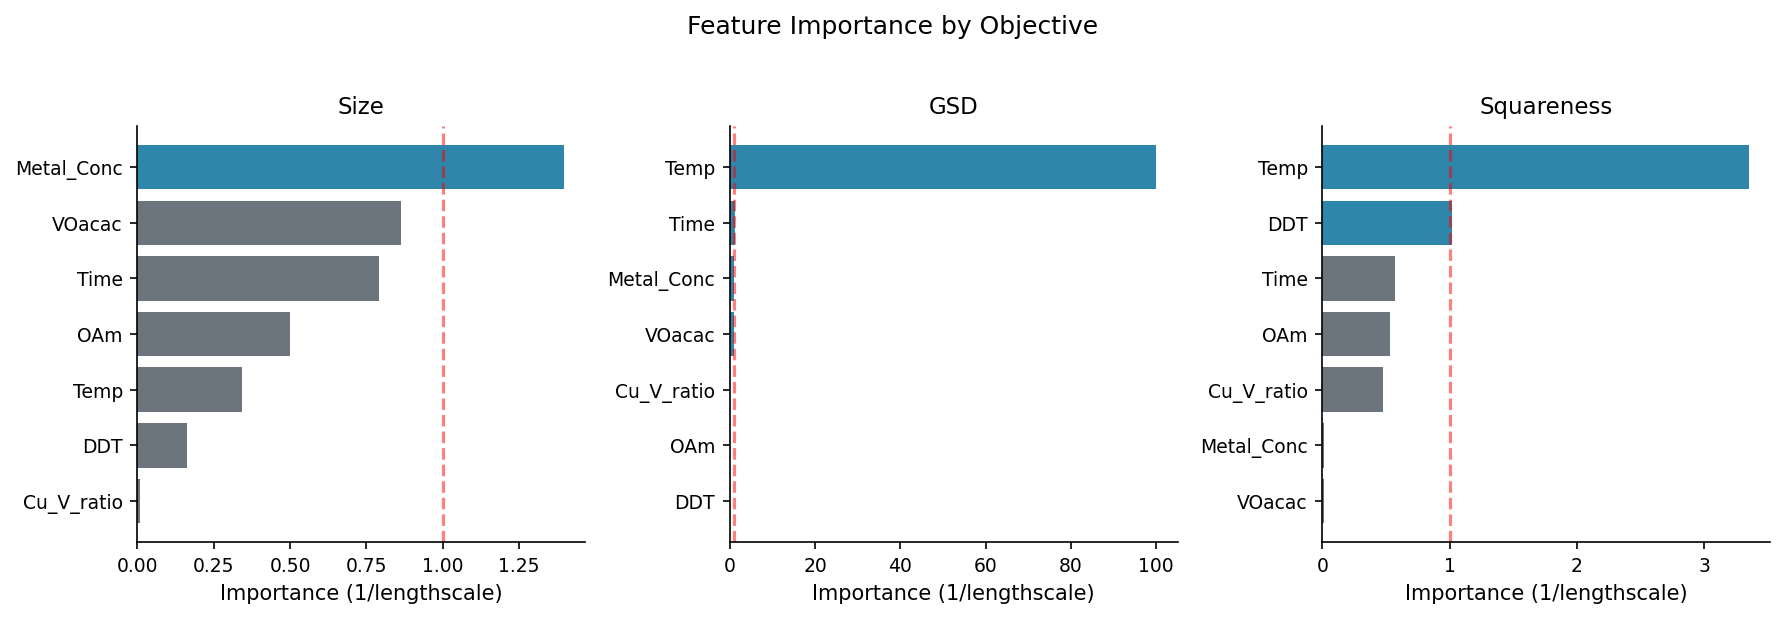

In [137]:
# =============================================================================
# LENGTHSCALE ANALYSIS
# =============================================================================

ls_df = model.get_lengthscales()

print("\n" + "=" * 70)
print("FEATURE IMPORTANCE (from GP lengthscales)")
print("=" * 70)
print("\nSmaller lengthscale = MORE important (function changes rapidly)")
print("Larger lengthscale = LESS important (function is flat)\n")

# Pivot for display
ls_pivot = ls_df.pivot(index='Feature', columns='Model', values='Lengthscale')
display(ls_pivot.round(2))

# Plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, obj in zip(axes, ['Size', 'GSD', 'Squareness']):
    data = ls_df[ls_df['Model'] == obj].sort_values('Importance', ascending=True)
    
    colors = [COLORS['primary'] if imp > 1 else COLORS['neutral'] 
              for imp in data['Importance']]
    
    ax.barh(data['Feature'], data['Importance'], color=colors)
    ax.set_xlabel('Importance (1/lengthscale)')
    ax.set_title(obj)
    ax.axvline(1.0, color='red', linestyle='--', alpha=0.5)

plt.suptitle('Feature Importance by Objective', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 9. Partial Dependence Analysis

These plots show *what the model learned* about how each feature affects the outcomes.


PARTIAL DEPENDENCE ANALYSIS


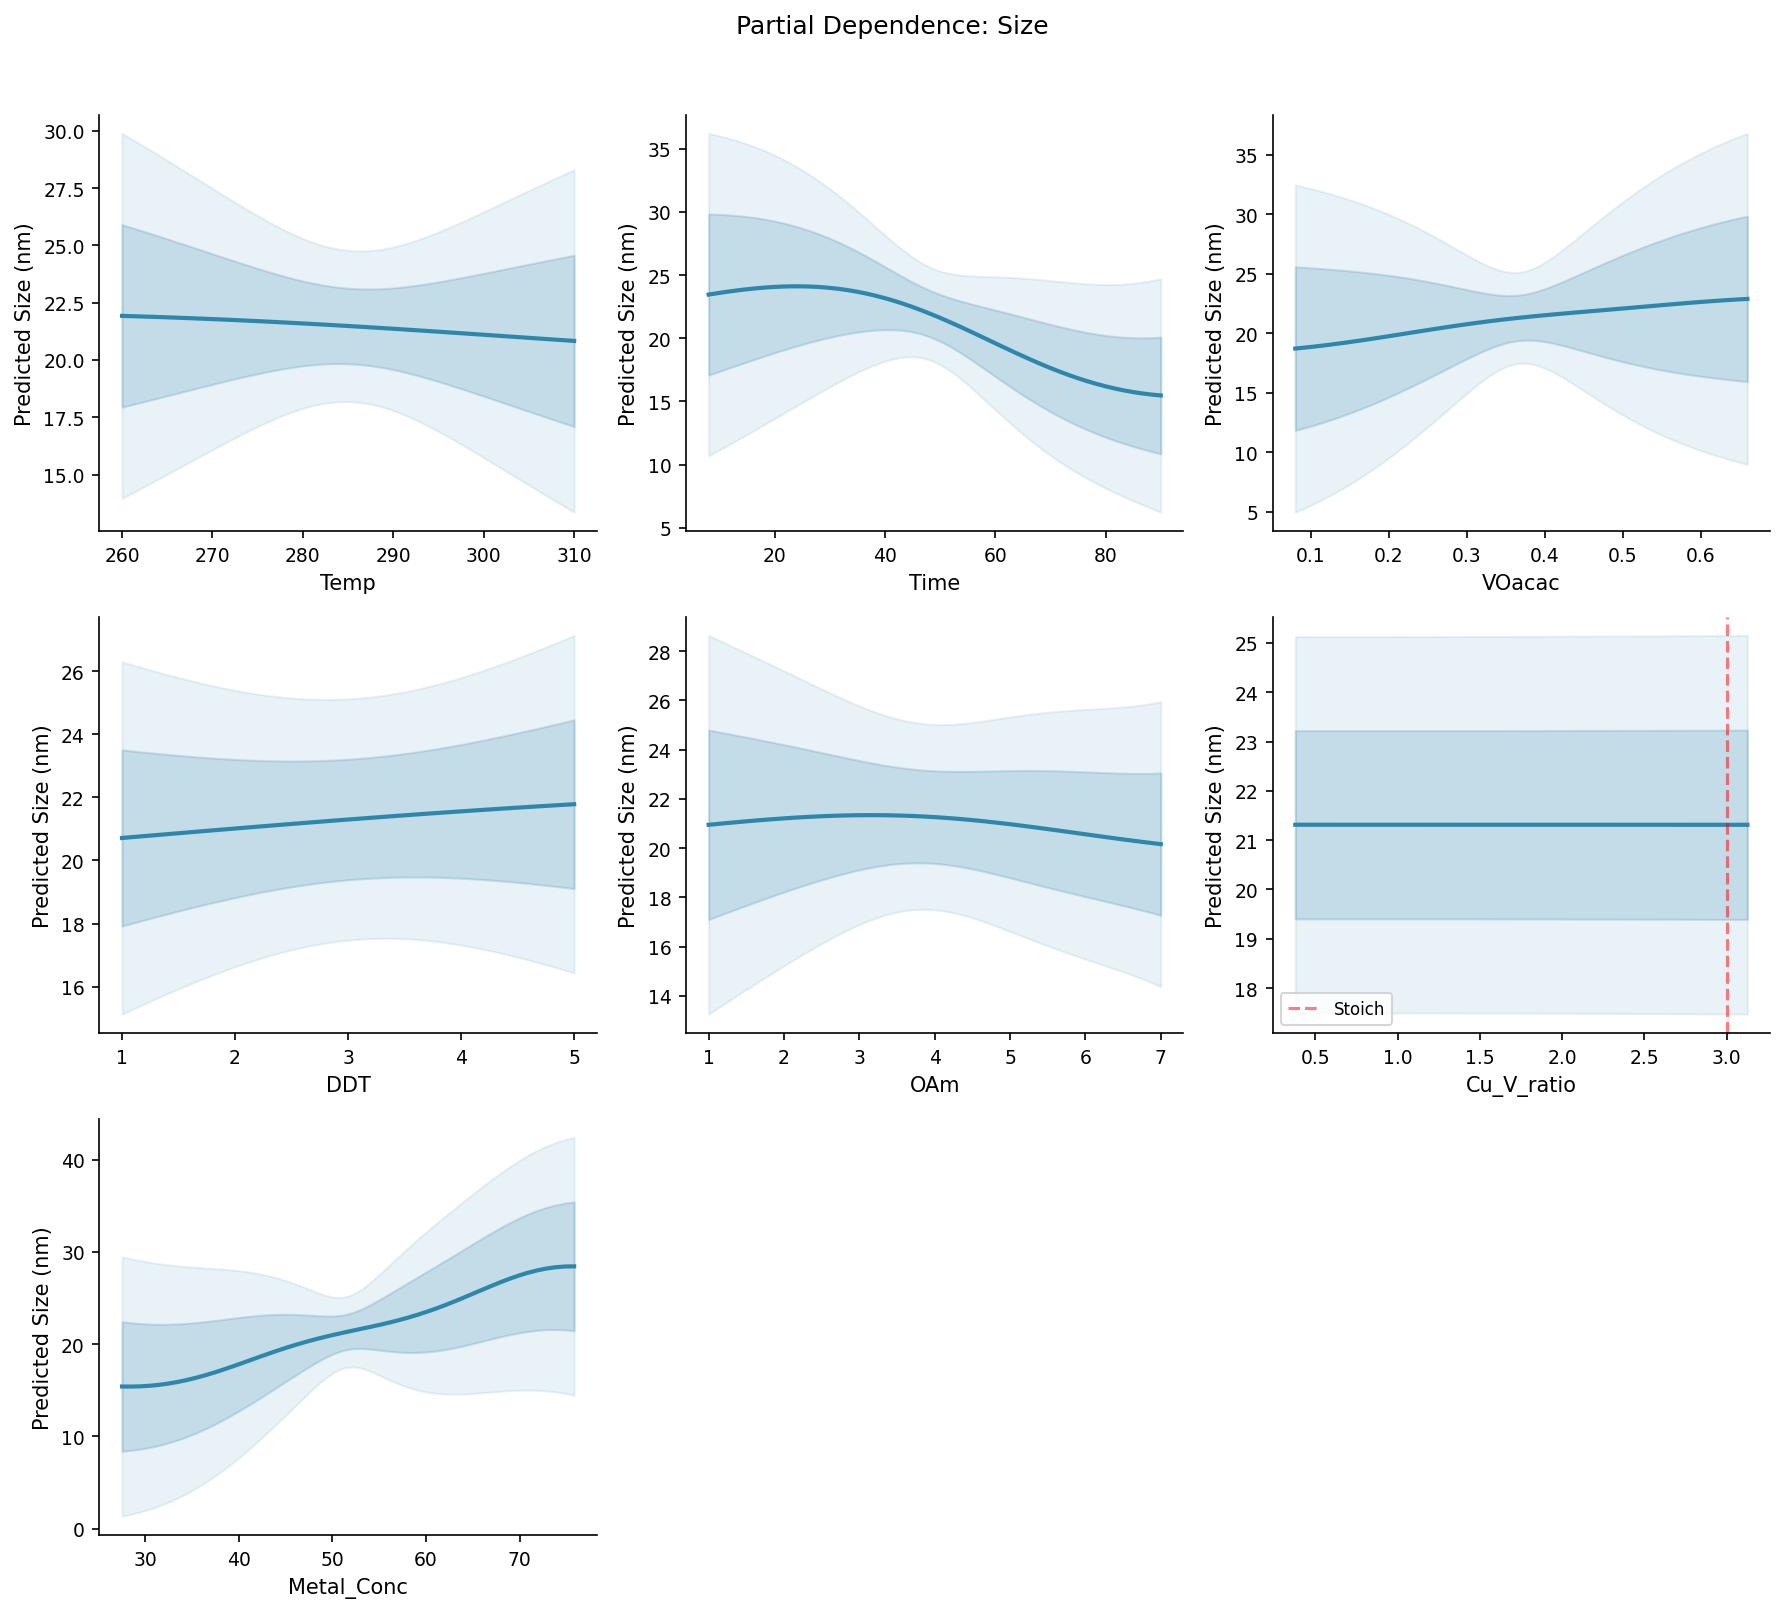


Interpretation:
  - Rising line: Higher feature value → larger particles
  - Falling line: Higher feature value → smaller particles
  - Flat line: Feature has little effect on size
  - Wide uncertainty band: Model is uncertain about this relationship


In [138]:
# =============================================================================
# PARTIAL DEPENDENCE PLOTS - SIZE
# =============================================================================

print("\n" + "=" * 70)
print("PARTIAL DEPENDENCE ANALYSIS")
print("=" * 70)

fig = plot_partial_dependence(model, target='size')
plt.savefig(OUTPUT_DIR / 'pdp_size.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("  - Rising line: Higher feature value → larger particles")
print("  - Falling line: Higher feature value → smaller particles")
print("  - Flat line: Feature has little effect on size")
print("  - Wide uncertainty band: Model is uncertain about this relationship")

In [139]:
# =============================================================================
# ENSURE OBJECTIVE WEIGHTS ARE SET (Safety check before optimization)
# =============================================================================

# This cell ensures that objective_weights is set and acquisition method is patched
# Run this before any optimization calls

if not hasattr(model, 'objective_weights') or model.objective_weights is None:
    print("\n[INFO] Setting up objective weights...")
    if OBJECTIVE_WEIGHTS is None:
        # Calculate weights
        calculated_weights = calculate_objective_weights(
            df_success=model.df_success,
            model_metrics=model.metrics,
            method='comprehensive'
        )
        model.objective_weights = calculated_weights
        print(f"✓ Calculated weights: {calculated_weights}")
    else:
        model.objective_weights = OBJECTIVE_WEIGHTS.copy()
        print(f"✓ Using manual weights: {model.objective_weights}")

# Patch acquisition method to use self.objective_weights instead of global OBJECTIVE_WEIGHTS
def patched_acquisition(self, X, target_size, size_tol):
    """Acquisition function using calculated weights from self.objective_weights."""
    preds = self.predict(X)
    gsd_best = self.df_success["GSD"].min()
    sq_best = self.df_success["Squareness"].max()
    ei_gsd = expected_improvement(preds['gsd_mu'], preds['gsd_std'], gsd_best, minimize=True)
    ei_sq = expected_improvement(preds['sq_mu'], preds['sq_std'], sq_best, minimize=False)
    ei_gsd_n = (ei_gsd - ei_gsd.min()) / (np.ptp(ei_gsd) + 1e-10)
    ei_sq_n = (ei_sq - ei_sq.min()) / (np.ptp(ei_sq) + 1e-10)
    
    # Use self.objective_weights (guaranteed to be set by code above)
    w_gsd = self.objective_weights.get("GSD", 1.0)
    w_sq = self.objective_weights.get("Squareness", 1.0)
    acq_obj = (w_gsd * ei_gsd_n + w_sq * ei_sq_n) / (w_gsd + w_sq)
    p_size = prob_in_interval(preds['size_mu'], preds['size_std'], target_size, size_tol)
    total = acq_obj * p_size * preds['p_feasible']
    return {'total': total, 'acq_obj': acq_obj, 'p_size': p_size, **preds}

import types
model.acquisition = types.MethodType(patched_acquisition, model)
print(f"✓ Acquisition method ready with weights: {model.objective_weights}")

✓ Acquisition method ready with weights: {'GSD': 0.8397068991521488, 'Squareness': 1.1602931008478512}


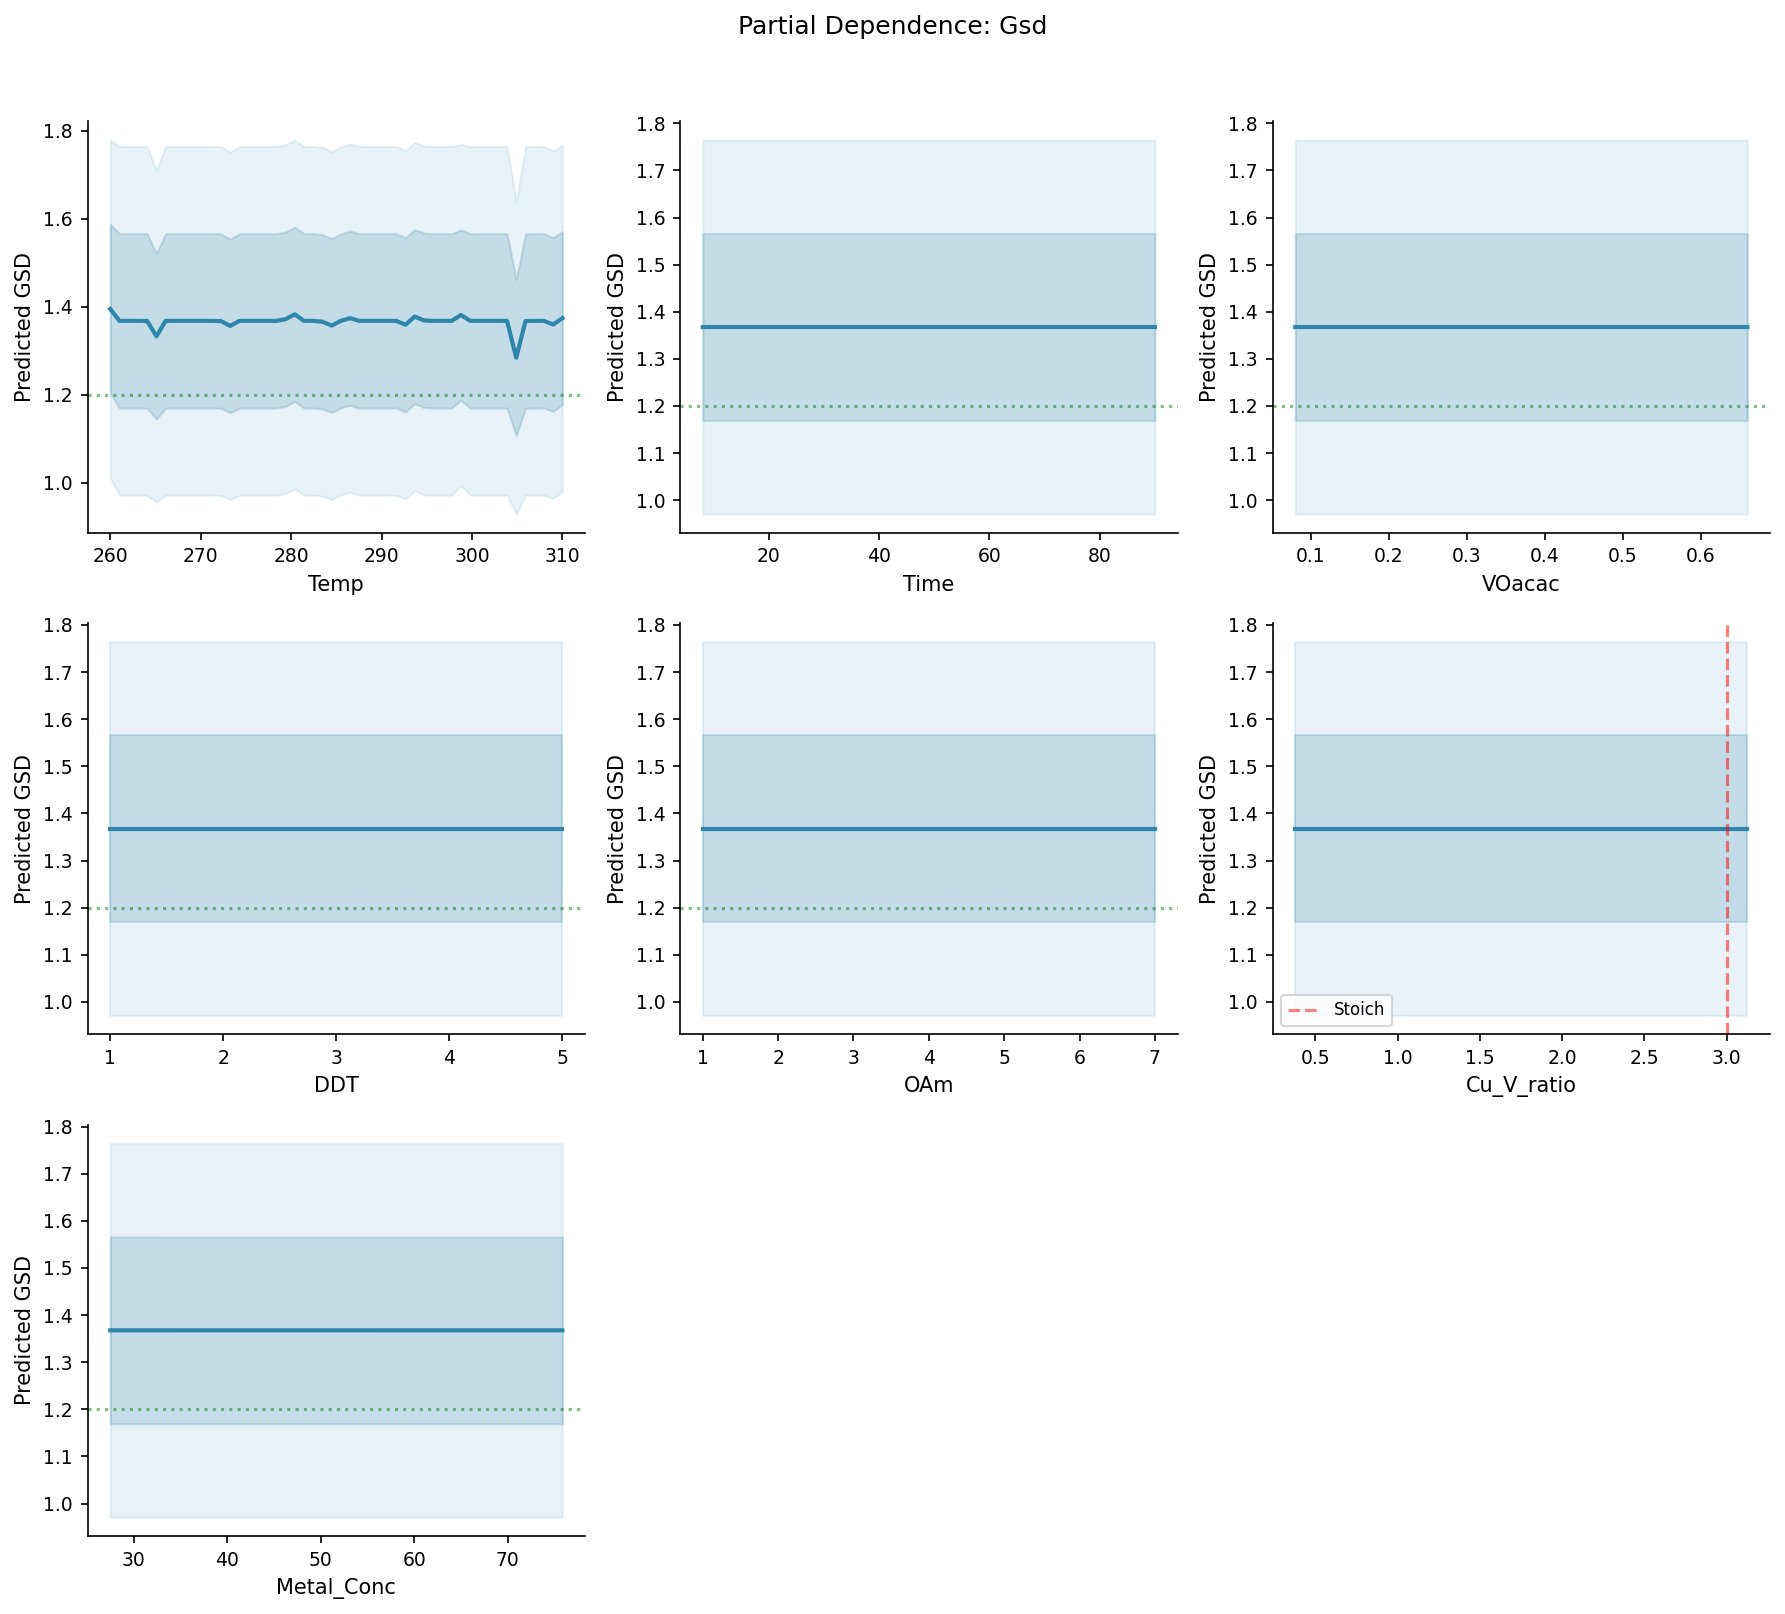


Interpretation for GSD (lower is better):
  - Falling line: Higher feature value → more monodisperse (GOOD)
  - Rising line: Higher feature value → more polydisperse (BAD)


In [140]:
# =============================================================================
# PARTIAL DEPENDENCE PLOTS - GSD
# =============================================================================

fig = plot_partial_dependence(model, target='gsd')
plt.savefig(OUTPUT_DIR / 'pdp_gsd.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation for GSD (lower is better):")
print("  - Falling line: Higher feature value → more monodisperse (GOOD)")
print("  - Rising line: Higher feature value → more polydisperse (BAD)")

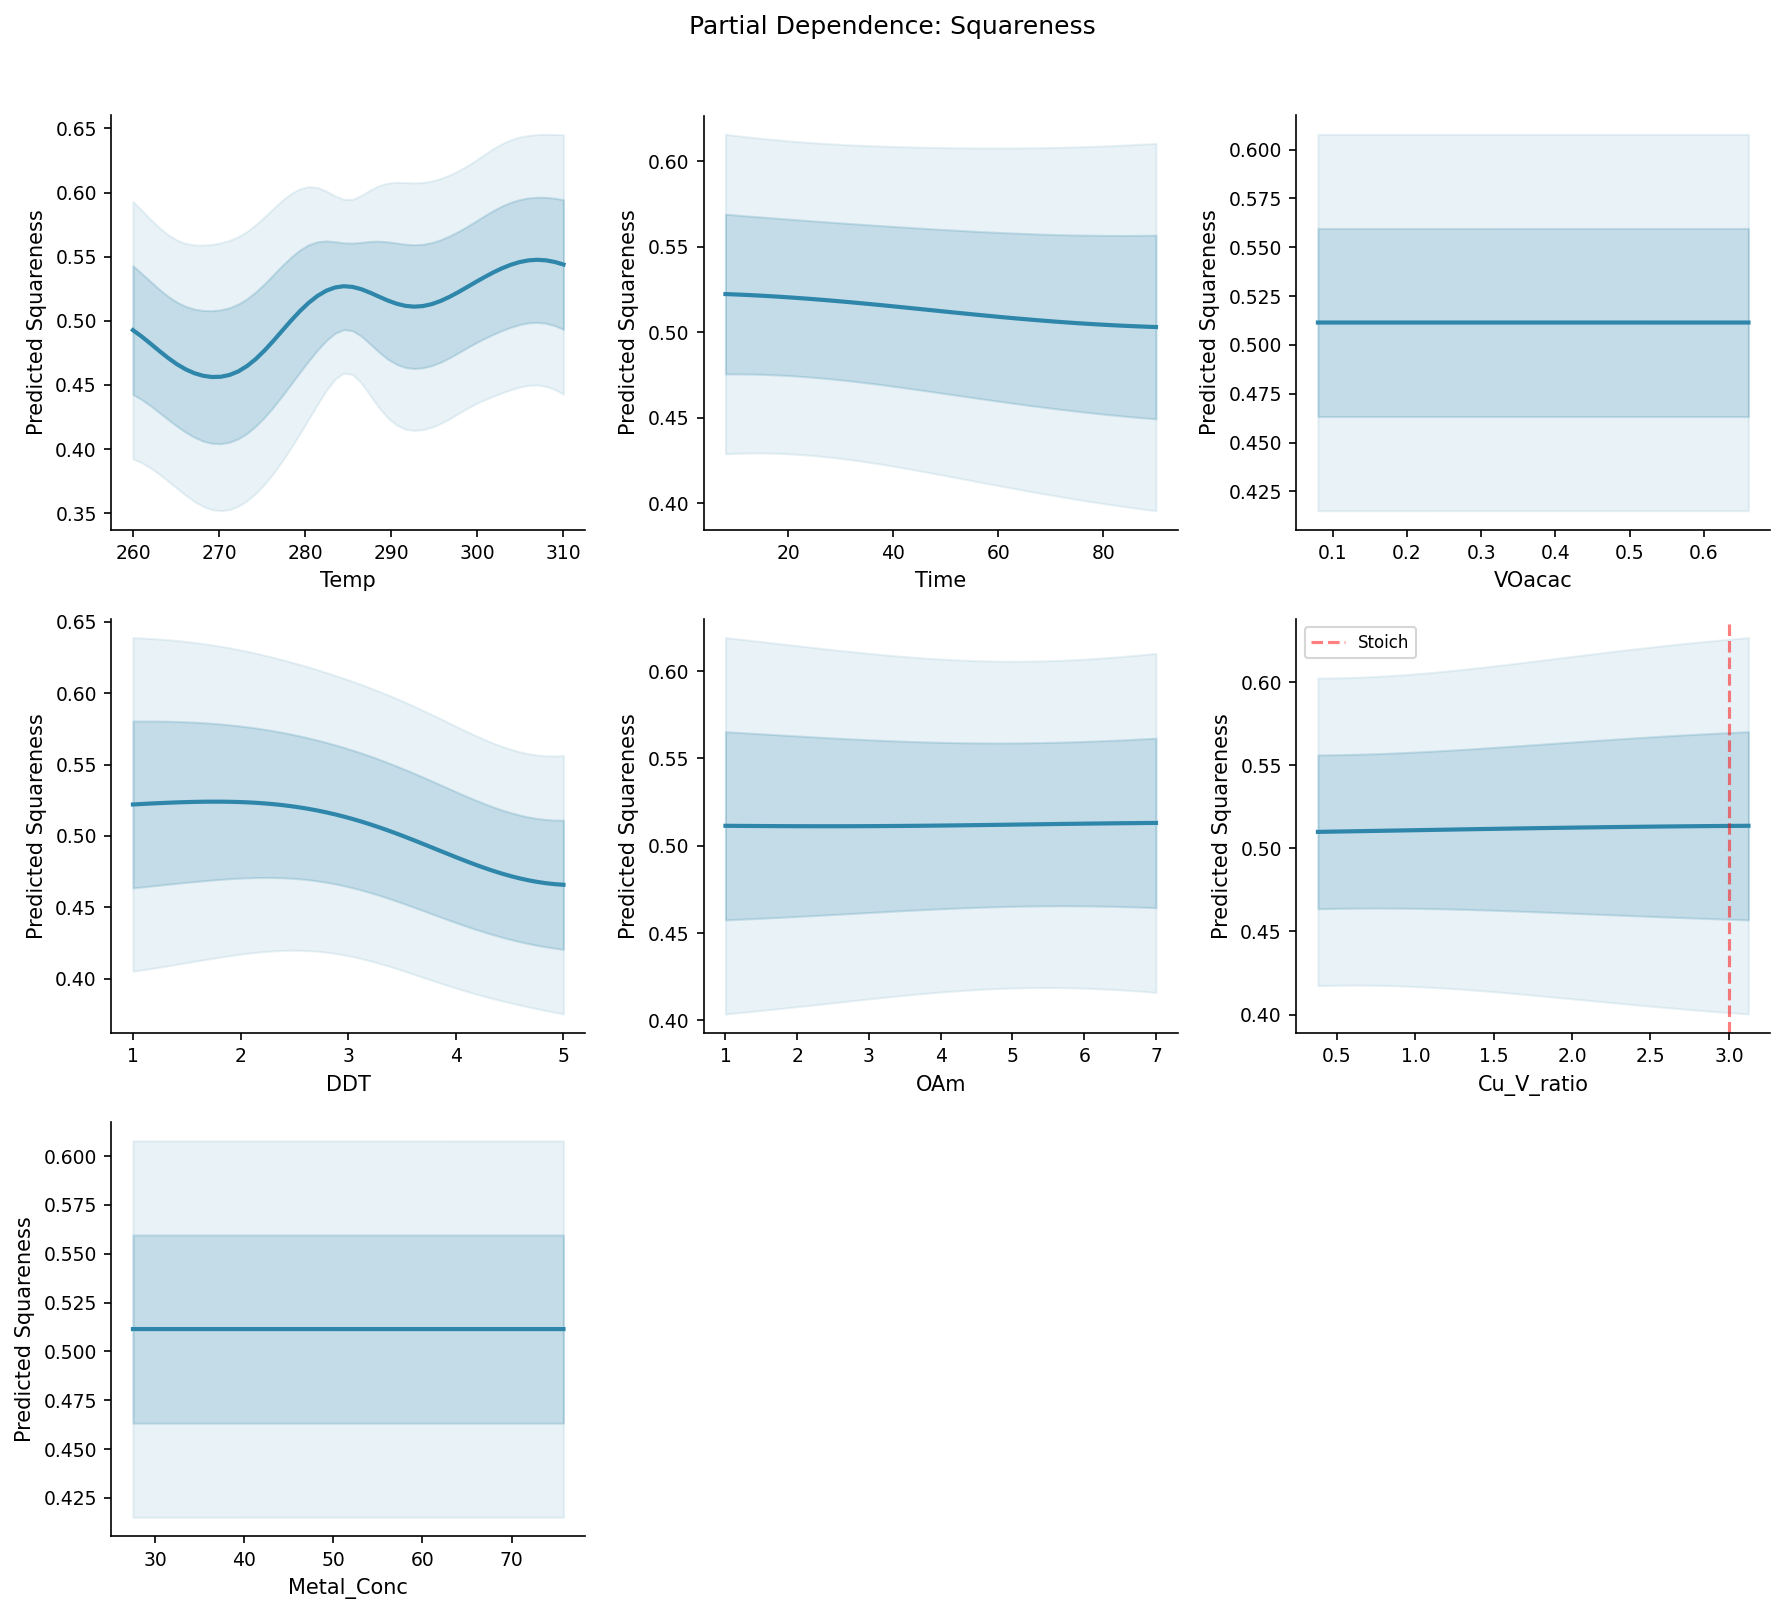


Interpretation for Squareness (higher is better):
  - Rising line: Higher feature value → more cubic (GOOD)
  - Falling line: Higher feature value → less cubic (BAD)


In [141]:
# =============================================================================
# PARTIAL DEPENDENCE PLOTS - SQUARENESS
# =============================================================================

fig = plot_partial_dependence(model, target='squareness')
plt.savefig(OUTPUT_DIR / 'pdp_squareness.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation for Squareness (higher is better):")
print("  - Rising line: Higher feature value → more cubic (GOOD)")
print("  - Falling line: Higher feature value → less cubic (BAD)")

---
## 10a. Predict Outcomes from Reaction Conditions

Input your synthesis conditions below to get model predictions for particle properties and feasibility.

In [142]:
# =============================================================================
# PREDICT OUTCOMES FROM REACTION CONDITIONS
# =============================================================================

def predict_from_conditions(
    Temp: float,
    Time: float,
    VOacac: float,
    DDT: float,
    OAm: float,
    model: Cu3VS4Optimizer = None,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Predict nanoparticle properties from raw synthesis conditions.
    
    Parameters
    ----------
    Temp : float
        Temperature (°C)
    Time : float
        Reaction time (minutes)
    VOacac : float
        Vanadium precursor amount (mmol)
    DDT : float
        Dodecanethiol volume (mL)
    OAm : float
        Oleylamine volume (mL)
    model : Cu3VS4Optimizer, optional
        Model to use for predictions (defaults to global 'model')
    verbose : bool
        Print detailed results
    
    Returns
    -------
    DataFrame with predictions and feasibility probabilities
    """
    if model is None:
        if 'model' not in globals():
            raise ValueError("Model not found. Please ensure 'model' is defined or pass model explicitly.")
        model = globals()['model']
    
    # Create input array in the model's feature space
    if model.feature_mode == 'raw':
        X_input = np.array([[Temp, Time, VOacac, DDT, OAm]])
    elif model.feature_mode == 'chemical':
        # Convert to chemical features
        chem = raw_to_chemical_features(
            Temp=np.array([Temp]),
            Time=np.array([Time]),
            VOacac=np.array([VOacac]),
            DDT=np.array([DDT]),
            OAm=np.array([OAm])
        )
        X_input = np.array([[chem['Cu_V_ratio'][0], chem['S_Metal_ratio'][0], 
                            chem['Ligand_Metal_ratio'][0], chem['Metal_Conc'][0], 
                            chem['log_Time'][0]]])
    elif model.feature_mode == 'hybrid':
        # Hybrid: raw + chemical features
        chem = raw_to_chemical_features(
            Temp=np.array([Temp]),
            Time=np.array([Time]),
            VOacac=np.array([VOacac]),
            DDT=np.array([DDT]),
            OAm=np.array([OAm])
        )
        X_input = np.array([[Temp, Time, VOacac, DDT, OAm, 
                            chem['Cu_V_ratio'][0], chem['Metal_Conc'][0]]])
    else:
        raise ValueError(f"Unknown feature_mode: {model.feature_mode}")
    
    # Get predictions
    preds = model.predict(X_input)
    
    # Create results dataframe
    results = pd.DataFrame({
        'Input_Conditions': {
            'Temp (°C)': f"{Temp:.1f}",
            'Time (min)': f"{Time:.1f}",
            'VOacac (mmol)': f"{VOacac:.3f}",
            'DDT (mL)': f"{DDT:.2f}",
            'OAm (mL)': f"{OAm:.2f}",
        },
        'Predicted_Properties': {
            'Size (nm)': f"{preds['size_mu'][0]:.2f} ± {preds['size_std'][0]:.2f}",
            'GSD': f"{preds['gsd_mu'][0]:.3f} ± {preds['gsd_std'][0]:.3f}",
            'Squareness': f"{preds['sq_mu'][0]:.3f} ± {preds['sq_std'][0]:.3f}",
        },
        'Feasibility_Probabilities': {
            'P(Product)': f"{preds['p_product'][0]:.3f}",
            'P(Phase Pure)': f"{preds['p_pure'][0]:.3f}",
            'P(Cubic)': f"{preds['p_cubic'][0]:.3f}",
            'P(Feasible)': f"{preds['p_feasible'][0]:.3f}",
        }
    })
    
    if verbose:
        print("=" * 70)
        print("PREDICTION RESULTS")
        print("=" * 70)
        print(f"\nInput Conditions:")
        print(f"  Temperature:     {Temp:.1f} °C")
        print(f"  Time:            {Time:.1f} min")
        print(f"  VOacac:          {VOacac:.3f} mmol")
        print(f"  DDT:             {DDT:.2f} mL")
        print(f"  OAm:             {OAm:.2f} mL")
        
        # Calculate chemical features for display
        chem = raw_to_chemical_features(
            Temp=np.array([Temp]),
            Time=np.array([Time]),
            VOacac=np.array([VOacac]),
            DDT=np.array([DDT]),
            OAm=np.array([OAm])
        )
        print(f"\nDerived Chemical Features:")
        print(f"  Cu:V ratio:      {chem['Cu_V_ratio'][0]:.3f} (target = 3.0)")
        print(f"  Metal Conc:     {chem['Metal_Conc'][0]:.2f} mM")
        print(f"  S:Metal ratio:   {chem['S_Metal_ratio'][0]:.3f}")
        print(f"  Ligand:Metal:    {chem['Ligand_Metal_ratio'][0]:.3f}")
        
        print(f"\nPredicted Properties:")
        print(f"  Size:           {preds['size_mu'][0]:.2f} ± {preds['size_std'][0]:.2f} nm")
        print(f"  GSD:            {preds['gsd_mu'][0]:.3f} ± {preds['gsd_std'][0]:.3f} (lower is better, ideal = 1.0)")
        print(f"  Squareness:     {preds['sq_mu'][0]:.3f} ± {preds['sq_std'][0]:.3f} (higher is better, ideal = 1.0)")
        
        print(f"\nFeasibility Probabilities:")
        print(f"  P(Product):     {preds['p_product'][0]:.3f}")
        print(f"  P(Phase Pure):  {preds['p_pure'][0]:.3f}")
        print(f"  P(Cubic):       {preds['p_cubic'][0]:.3f}")
        print(f"  P(Feasible):    {preds['p_feasible'][0]:.3f} (combined)")
        
        # Interpretation
        print(f"\nInterpretation:")
        if preds['p_feasible'][0] > 0.7:
            print(f"  ✓ High feasibility - good chance of success")
        elif preds['p_feasible'][0] > 0.4:
            print(f"  ⚠ Moderate feasibility - may work but uncertain")
        else:
            print(f"  ✗ Low feasibility - unlikely to succeed")
        
        if preds['gsd_mu'][0] < 1.2:
            print(f"  ✓ Predicted GSD is good (monodisperse)")
        elif preds['gsd_mu'][0] < 1.4:
            print(f"  ⚠ Predicted GSD is moderate")
        else:
            print(f"  ✗ Predicted GSD is high (polydisperse)")
        
        if preds['sq_mu'][0] > 0.8:
            print(f"  ✓ Predicted squareness is good (cubic)")
        elif preds['sq_mu'][0] > 0.6:
            print(f"  ⚠ Predicted squareness is moderate")
        else:
            print(f"  ✗ Predicted squareness is low (non-cubic)")
        
        print("=" * 70)
    
    return results


# =============================================================================
# EXAMPLE USAGE
# =============================================================================

# Example 1: Predict for specific conditions
# Uncomment and modify these values to test your own conditions:

# result = predict_from_conditions(
#     Temp=280.0,      # Temperature in °C
#     Time=30.0,        # Time in minutes
#     VOacac=0.15,      # Vanadium precursor (mmol)
#     DDT=3.0,          # Dodecanethiol (mL)
#     OAm=4.0,          # Oleylamine (mL)
#     model=model,      # Use the trained model
#     verbose=True
# )

# Example 2: Batch prediction for multiple conditions
def predict_batch(conditions_list: List[Dict[str, float]], model: Cu3VS4Optimizer = None) -> pd.DataFrame:
    """
    Predict outcomes for multiple reaction conditions.
    
    Parameters
    ----------
    conditions_list : list of dicts
        Each dict should have keys: 'Temp', 'Time', 'VOacac', 'DDT', 'OAm'
    model : Cu3VS4Optimizer, optional
        Model to use (defaults to global 'model')
    
    Returns
    -------
    DataFrame with predictions for all conditions
    """
    if model is None:
        model = globals()['model']
    
    results = []
    for i, cond in enumerate(conditions_list):
        # Convert to model's feature space (same logic as predict_from_conditions)
        if model.feature_mode == 'raw':
            X_input = np.array([[cond['Temp'], cond['Time'], cond['VOacac'], cond['DDT'], cond['OAm']]])
        elif model.feature_mode == 'chemical':
            chem = raw_to_chemical_features(
                Temp=np.array([cond['Temp']]),
                Time=np.array([cond['Time']]),
                VOacac=np.array([cond['VOacac']]),
                DDT=np.array([cond['DDT']]),
                OAm=np.array([cond['OAm']])
            )
            X_input = np.array([[chem['Cu_V_ratio'][0], chem['S_Metal_ratio'][0], 
                                chem['Ligand_Metal_ratio'][0], chem['Metal_Conc'][0], 
                                chem['log_Time'][0]]])
        elif model.feature_mode == 'hybrid':
            chem = raw_to_chemical_features(
                Temp=np.array([cond['Temp']]),
                Time=np.array([cond['Time']]),
                VOacac=np.array([cond['VOacac']]),
                DDT=np.array([cond['DDT']]),
                OAm=np.array([cond['OAm']])
            )
            X_input = np.array([[cond['Temp'], cond['Time'], cond['VOacac'], cond['DDT'], cond['OAm'], 
                                chem['Cu_V_ratio'][0], chem['Metal_Conc'][0]]])
        else:
            raise ValueError(f"Unknown feature_mode: {model.feature_mode}")
        
        # Get predictions
        pred_dict = model.predict(X_input)
        
        results.append({
            'Condition_ID': i + 1,
            'Temp': cond['Temp'],
            'Time': cond['Time'],
            'VOacac': cond['VOacac'],
            'DDT': cond['DDT'],
            'OAm': cond['OAm'],
            'Pred_Size': pred_dict['size_mu'][0],
            'Pred_Size_Std': pred_dict['size_std'][0],
            'Pred_GSD': pred_dict['gsd_mu'][0],
            'Pred_GSD_Std': pred_dict['gsd_std'][0],
            'Pred_Squareness': pred_dict['sq_mu'][0],
            'Pred_Squareness_Std': pred_dict['sq_std'][0],
            'P_Product': pred_dict['p_product'][0],
            'P_Pure': pred_dict['p_pure'][0],
            'P_Cubic': pred_dict['p_cubic'][0],
            'P_Feasible': pred_dict['p_feasible'][0],
        })
    
    return pd.DataFrame(results)

# Example batch usage:
# conditions = [
#     {'Temp': 280.0, 'Time': 30.0, 'VOacac': 0.15, 'DDT': 3.0, 'OAm': 4.0},
#     {'Temp': 290.0, 'Time': 45.0, 'VOacac': 0.20, 'DDT': 3.5, 'OAm': 5.0},
# ]
# batch_results = predict_batch(conditions, model=model)
# display(batch_results)

print("✓ Prediction functions loaded!")
print("\nTo use:")
print("  1. Call predict_from_conditions(Temp, Time, VOacac, DDT, OAm)")
print("  2. Or use predict_batch() for multiple conditions")
print("\nSee examples in the code above (uncomment to run).")

✓ Prediction functions loaded!

To use:
  1. Call predict_from_conditions(Temp, Time, VOacac, DDT, OAm)
  2. Or use predict_batch() for multiple conditions

See examples in the code above (uncomment to run).


In [143]:
result = predict_from_conditions(
    Temp=297.0,      # Temperature in °C
    Time=14.0,        # Time in minutes
    VOacac=0.594,      # Vanadium precursor (mmol)
    DDT=2.3,          # Dodecanethiol (mL)
    OAm=6.2,          # Oleylamine (mL)
    model=model,
    verbose=True
)

PREDICTION RESULTS

Input Conditions:
  Temperature:     297.0 °C
  Time:            14.0 min
  VOacac:          0.594 mmol
  DDT:             2.30 mL
  OAm:             6.20 mL

Derived Chemical Features:
  Cu:V ratio:      0.421 (target = 3.0)
  Metal Conc:     70.33 mM
  S:Metal ratio:   11.364
  Ligand:Metal:    22.332

Predicted Properties:
  Size:           19.71 ± 2.36 nm
  GSD:            1.368 ± 0.198 (lower is better, ideal = 1.0)
  Squareness:     0.530 ± 0.047 (higher is better, ideal = 1.0)

Feasibility Probabilities:
  P(Product):     0.876
  P(Phase Pure):  0.545
  P(Cubic):       0.726
  P(Feasible):    0.347 (combined)

Interpretation:
  ✗ Low feasibility - unlikely to succeed
  ⚠ Predicted GSD is moderate
  ✗ Predicted squareness is low (non-cubic)


---
## 10. Optimization

In [144]:
# =============================================================================
# SINGLE TARGET OPTIMIZATION
# =============================================================================

TARGET_SIZE = 18.242
SIZE_TOL = 1.0

print(f"\n" + "=" * 70)
print(f"OPTIMIZATION: Target {TARGET_SIZE} ± {SIZE_TOL} nm")
print("=" * 70)

recommendations = model.recommend(
    target_size=TARGET_SIZE,
    size_tol=SIZE_TOL,
    p_size_min=0.15,
    p_feas_min=0.25,
    n_candidates=25000,
    n_return=5,
    seed=42
)

print("\nRecommended Conditions:")
display(recommendations)


OPTIMIZATION: Target 18.242 ± 1.0 nm

Recommended Conditions:


,Rank,Temp,Time,VOacac,DDT,OAm,Pred_Size,Pred_Size_Std,Pred_GSD,Pred_Squareness,P_Size,P_Feasible,Acquisition
0,1,309.940,11.607,0.614,1.029,1.381,20.15,2.92,1.256,0.588,0.218,0.644,0.1023
1,2,309.180,26.571,0.259,2.232,1.909,17.71,4.59,1.340,0.571,0.171,0.687,0.0792
2,3,309.478,63.566,0.257,2.599,2.572,18.08,4.58,1.365,0.563,0.173,0.616,0.0638
3,4,309.942,50.780,0.359,2.490,1.536,21.14,4.03,1.372,0.566,0.152,0.661,0.0608
4,5,308.647,57.608,0.276,1.853,2.741,18.66,4.30,1.364,0.562,0.183,0.646,0.0600


In [145]:
# =============================================================================
# SIZE SWEEP
# =============================================================================

print("\n" + "=" * 70)
print("SIZE SWEEP OPTIMIZATION")
print("=" * 70)

size_targets = [12, 15, 18, 20, 25, 30]
sweep_results = []

for target in size_targets:
    try:
        recs = model.recommend(
            target_size=target,
            size_tol=2.5,
            p_size_min=0.10,
            p_feas_min=0.20,
            n_candidates=15000,
            n_return=1,
            seed=42
        )
        if len(recs) > 0:
            row = recs.iloc[0].to_dict()
            row['Target'] = target
            sweep_results.append(row)
            print(f"  {target}nm: Pred={row['Pred_Size']:.1f}nm, GSD={row['Pred_GSD']:.3f}")
    except Exception as e:
        print(f"  {target}nm: Failed - {e}")

sweep_df = pd.DataFrame(sweep_results)
print("\nFull sweep results:")
display(sweep_df)


SIZE SWEEP OPTIMIZATION
  12nm: Pred=12.5nm, GSD=1.363
  15nm: Pred=12.5nm, GSD=1.363
  18nm: Pred=18.8nm, GSD=1.369
  20nm: Pred=20.2nm, GSD=1.367
  25nm: Pred=26.8nm, GSD=1.370
  30nm: Pred=31.9nm, GSD=1.367

Full sweep results:


,Rank,Temp,Time,VOacac,DDT,OAm,Pred_Size,Pred_Size_Std,Pred_GSD,Pred_Squareness,P_Size,P_Feasible,Acquisition,Target
0,1.0,309.499,21.197,0.144,2.169,1.362,12.46,3.72,1.363,0.578,0.495,0.660,0.2322,12
1,1.0,309.499,21.197,0.144,2.169,1.362,12.46,3.72,1.363,0.578,0.408,0.660,0.1914,15
2,1.0,309.534,61.797,0.338,1.590,3.502,18.77,4.43,1.369,0.579,0.421,0.535,0.1575,18
3,1.0,308.377,47.447,0.389,2.153,1.853,20.20,4.87,1.367,0.574,0.392,0.601,0.1624,20
4,1.0,309.355,60.071,0.570,2.057,3.856,26.78,4.35,1.370,0.558,0.403,0.700,0.1312,25
5,1.0,308.537,65.198,0.616,1.082,2.646,31.95,4.65,1.367,0.579,0.378,0.508,0.1290,30


---
## 11. Parity Plots

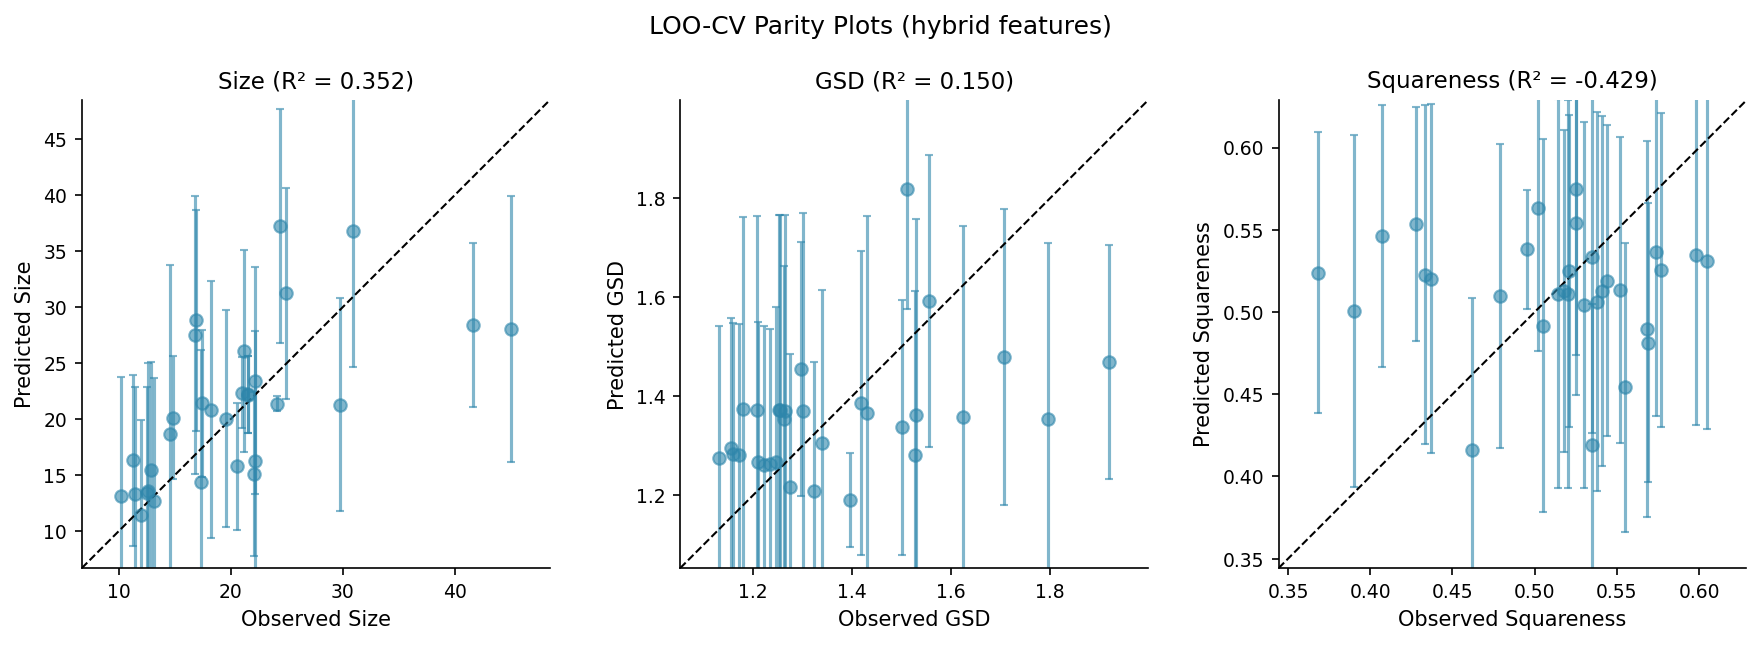

In [146]:
# =============================================================================
# PARITY PLOTS
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, name in zip(axes, ['Size', 'GSD', 'Squareness']):
    y_true = model.df_success[name].values
    y_pred = model.metrics[name]['y_pred']
    y_std = model.metrics[name]['y_std']
    r2 = model.metrics[name]['r2']
    
    ax.errorbar(y_true, y_pred, yerr=1.96*y_std, fmt='o', alpha=0.6,
                capsize=2, markersize=6, color=COLORS['primary'])
    
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    margin = 0.1 * (lims[1] - lims[0])
    lims = [lims[0] - margin, lims[1] + margin]
    ax.plot(lims, lims, 'k--', lw=1)
    
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(f'Observed {name}')
    ax.set_ylabel(f'Predicted {name}')
    ax.set_title(f'{name} (R² = {r2:.3f})')
    ax.set_aspect('equal')

plt.suptitle(f'LOO-CV Parity Plots ({model.feature_mode} features)', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'parity_plots.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 12. Export Results

In [147]:
# =============================================================================
# SAVE RESULTS
# =============================================================================

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Recommendations
rec_path = OUTPUT_DIR / f"recommendations_{TARGET_SIZE}nm_{timestamp}.csv"
recommendations.to_csv(rec_path, index=False)
print(f"Saved: {rec_path}")

# Sweep
if len(sweep_df) > 0:
    sweep_path = OUTPUT_DIR / f"size_sweep_{timestamp}.csv"
    sweep_df.to_csv(sweep_path, index=False)
    print(f"Saved: {sweep_path}")

# Model comparison
comp_path = OUTPUT_DIR / f"model_comparison_{timestamp}.csv"
comparison_df.to_csv(comp_path, index=False)
print(f"Saved: {comp_path}")

# Feature importance
feat_path = OUTPUT_DIR / f"feature_importance_{timestamp}.csv"
ls_df.to_csv(feat_path, index=False)
print(f"Saved: {feat_path}")

Saved: ../Outputs/recommendations_18.242nm_20260115_122015.csv
Saved: ../Outputs/size_sweep_20260115_122015.csv
Saved: ../Outputs/model_comparison_20260115_122015.csv
Saved: ../Outputs/feature_importance_20260115_122015.csv


In [148]:
# =============================================================================
# SESSION SUMMARY
# =============================================================================

print("\n" + "=" * 70)
print("SESSION SUMMARY")
print("=" * 70)
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nData:")
print(f"  Total experiments: {len(df)}")
print(f"  Successful: {len(df_success)}")
print(f"\nModel:")
print(f"  Feature mode: {model.feature_mode}")
print(f"  Features: {model.features}")
print(f"\nSystem constants:")
print(f"  CuI: {CUI_MMOL} mmol")
print(f"  Total volume: {TOTAL_VOLUME_ML} mL")
print(f"\nObjective weights:")
if hasattr(model, 'objective_weights') and model.objective_weights is not None:
    print(f"  GSD: {model.objective_weights.get('GSD', 'N/A')}")
    print(f"  Squareness: {model.objective_weights.get('Squareness', 'N/A')}")
    print(f"  (Calculated statistically from data and model performance)")
elif OBJECTIVE_WEIGHTS is not None:
    print(f"  GSD: {OBJECTIVE_WEIGHTS.get('GSD', 'N/A')}")
    print(f"  Squareness: {OBJECTIVE_WEIGHTS.get('Squareness', 'N/A')}")
    print(f"  (Manual weights)")
else:
    print(f"  GSD: 1.0 (default)")
    print(f"  Squareness: 1.0 (default)")
    print(f"  (Weights not calculated - using defaults)")


SESSION SUMMARY
Date: 2026-01-15 12:20:15

Data:
  Total experiments: 41
  Successful: 31

Model:
  Feature mode: hybrid
  Features: ['Temp', 'Time', 'VOacac', 'DDT', 'OAm', 'Cu_V_ratio', 'Metal_Conc']

System constants:
  CuI: 0.25 mmol
  Total volume: 12.0 mL

Objective weights:
  GSD: 0.8397068991521488
  Squareness: 1.1602931008478512
  (Calculated statistically from data and model performance)
